<a href="https://colab.research.google.com/github/matheusmopucrs/TCC/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TCC - Previsão de Ativos Financeiros com Inteligência Artificial
## Comparação entre Ações Brasileiras e Big Techs Americanas
### Modelos: LSTM → XGBoost/LightGBM → Ensemble (Melhor Resultado)

In [16]:
!pip install yfinance pandas numpy matplotlib scikit-learn tensorflow ta

In [17]:
# =============================================
# VERSÃO TURBO 2025 — GPU + Mixed Precision + Barra de Progresso
# =============================================
import yfinance as yf, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns, warnings
warnings.filterwarnings("ignore")

import ta

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from lightgbm import LGBMRegressor
from tqdm.notebook import tqdm
import tensorflow as tf


# ATIVAÇÃO TURBO (2–4× mais rápido)
tf.keras.mixed_precision.set_global_policy('mixed_float16')
print("GPUs:", tf.config.list_physical_devices('GPU'))
print("Mixed precision ativado → velocidade máxima!")

plt.style.use('seaborn-v0_8')
%matplotlib inline

GPUs: []
Mixed precision ativado → velocidade máxima!


In [18]:
# =============================================
# FUNÇÃO DE CARREGAMENTO DOS DADOS (já corrigida e otimizada)
# =============================================
def carregar_dados(tickers, start="2012-01-01", end="2025-01-01"):
    print(f"Baixando {len(tickers)} ativos...")
    data = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False, threads=True)
    close = data['Close']
    if len(tickers) == 1 or close.ndim == 1:
        close = close.to_frame(name=tickers[0])

    resultado = {}
    for ticker in tickers:
        if ticker not in close.columns:
            continue
        df = close[[ticker]].copy()
        df.columns = ['Close']
        df.dropna(inplace=True)
        if len(df) < 100:
            continue

        df['SMA_20'] = df['Close'].rolling(20).mean()
        df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        df.dropna(inplace=True)
        resultado[ticker] = df
        print(f"✓ {ticker}: {len(df)} dias")

    print(f"\n{len(resultado)} ativos carregados com sucesso!\n")
    return resultado

# =============================================
# CARREGAMENTO DOS ATIVOS
# =============================================
tickers_brasil = ["PETR4.SA","VALE3.SA","ITUB4.SA","BBDC4.SA","BBAS3.SA","ABEV3.SA",
                  "MGLU3.SA","WEGE3.SA","SUZB3.SA","EQTL3.SA"]

tickers_bigtech = ["AAPL","MSFT","GOOGL","AMZN","META","NVDA","TSLA","NFLX","ADBE","INTC"]

dados_brasil = carregar_dados(tickers_brasil)
dados_bigtech = carregar_dados(tickers_bigtech)

todos_ativos = {**dados_brasil, **dados_bigtech}

Baixando 10 ativos...
✓ PETR4.SA: 3209 dias
✓ VALE3.SA: 3209 dias
✓ ITUB4.SA: 3209 dias
✓ BBDC4.SA: 3209 dias
✓ BBAS3.SA: 3209 dias
✓ ABEV3.SA: 3209 dias
✓ MGLU3.SA: 3209 dias
✓ WEGE3.SA: 3209 dias
✓ SUZB3.SA: 1844 dias
✓ EQTL3.SA: 3209 dias

10 ativos carregados com sucesso!

Baixando 10 ativos...
✓ AAPL: 3251 dias
✓ MSFT: 3251 dias
✓ GOOGL: 3251 dias
✓ AMZN: 3251 dias
✓ META: 3156 dias
✓ NVDA: 3251 dias
✓ TSLA: 3251 dias
✓ NFLX: 3251 dias
✓ ADBE: 3251 dias
✓ INTC: 3251 dias

10 ativos carregados com sucesso!



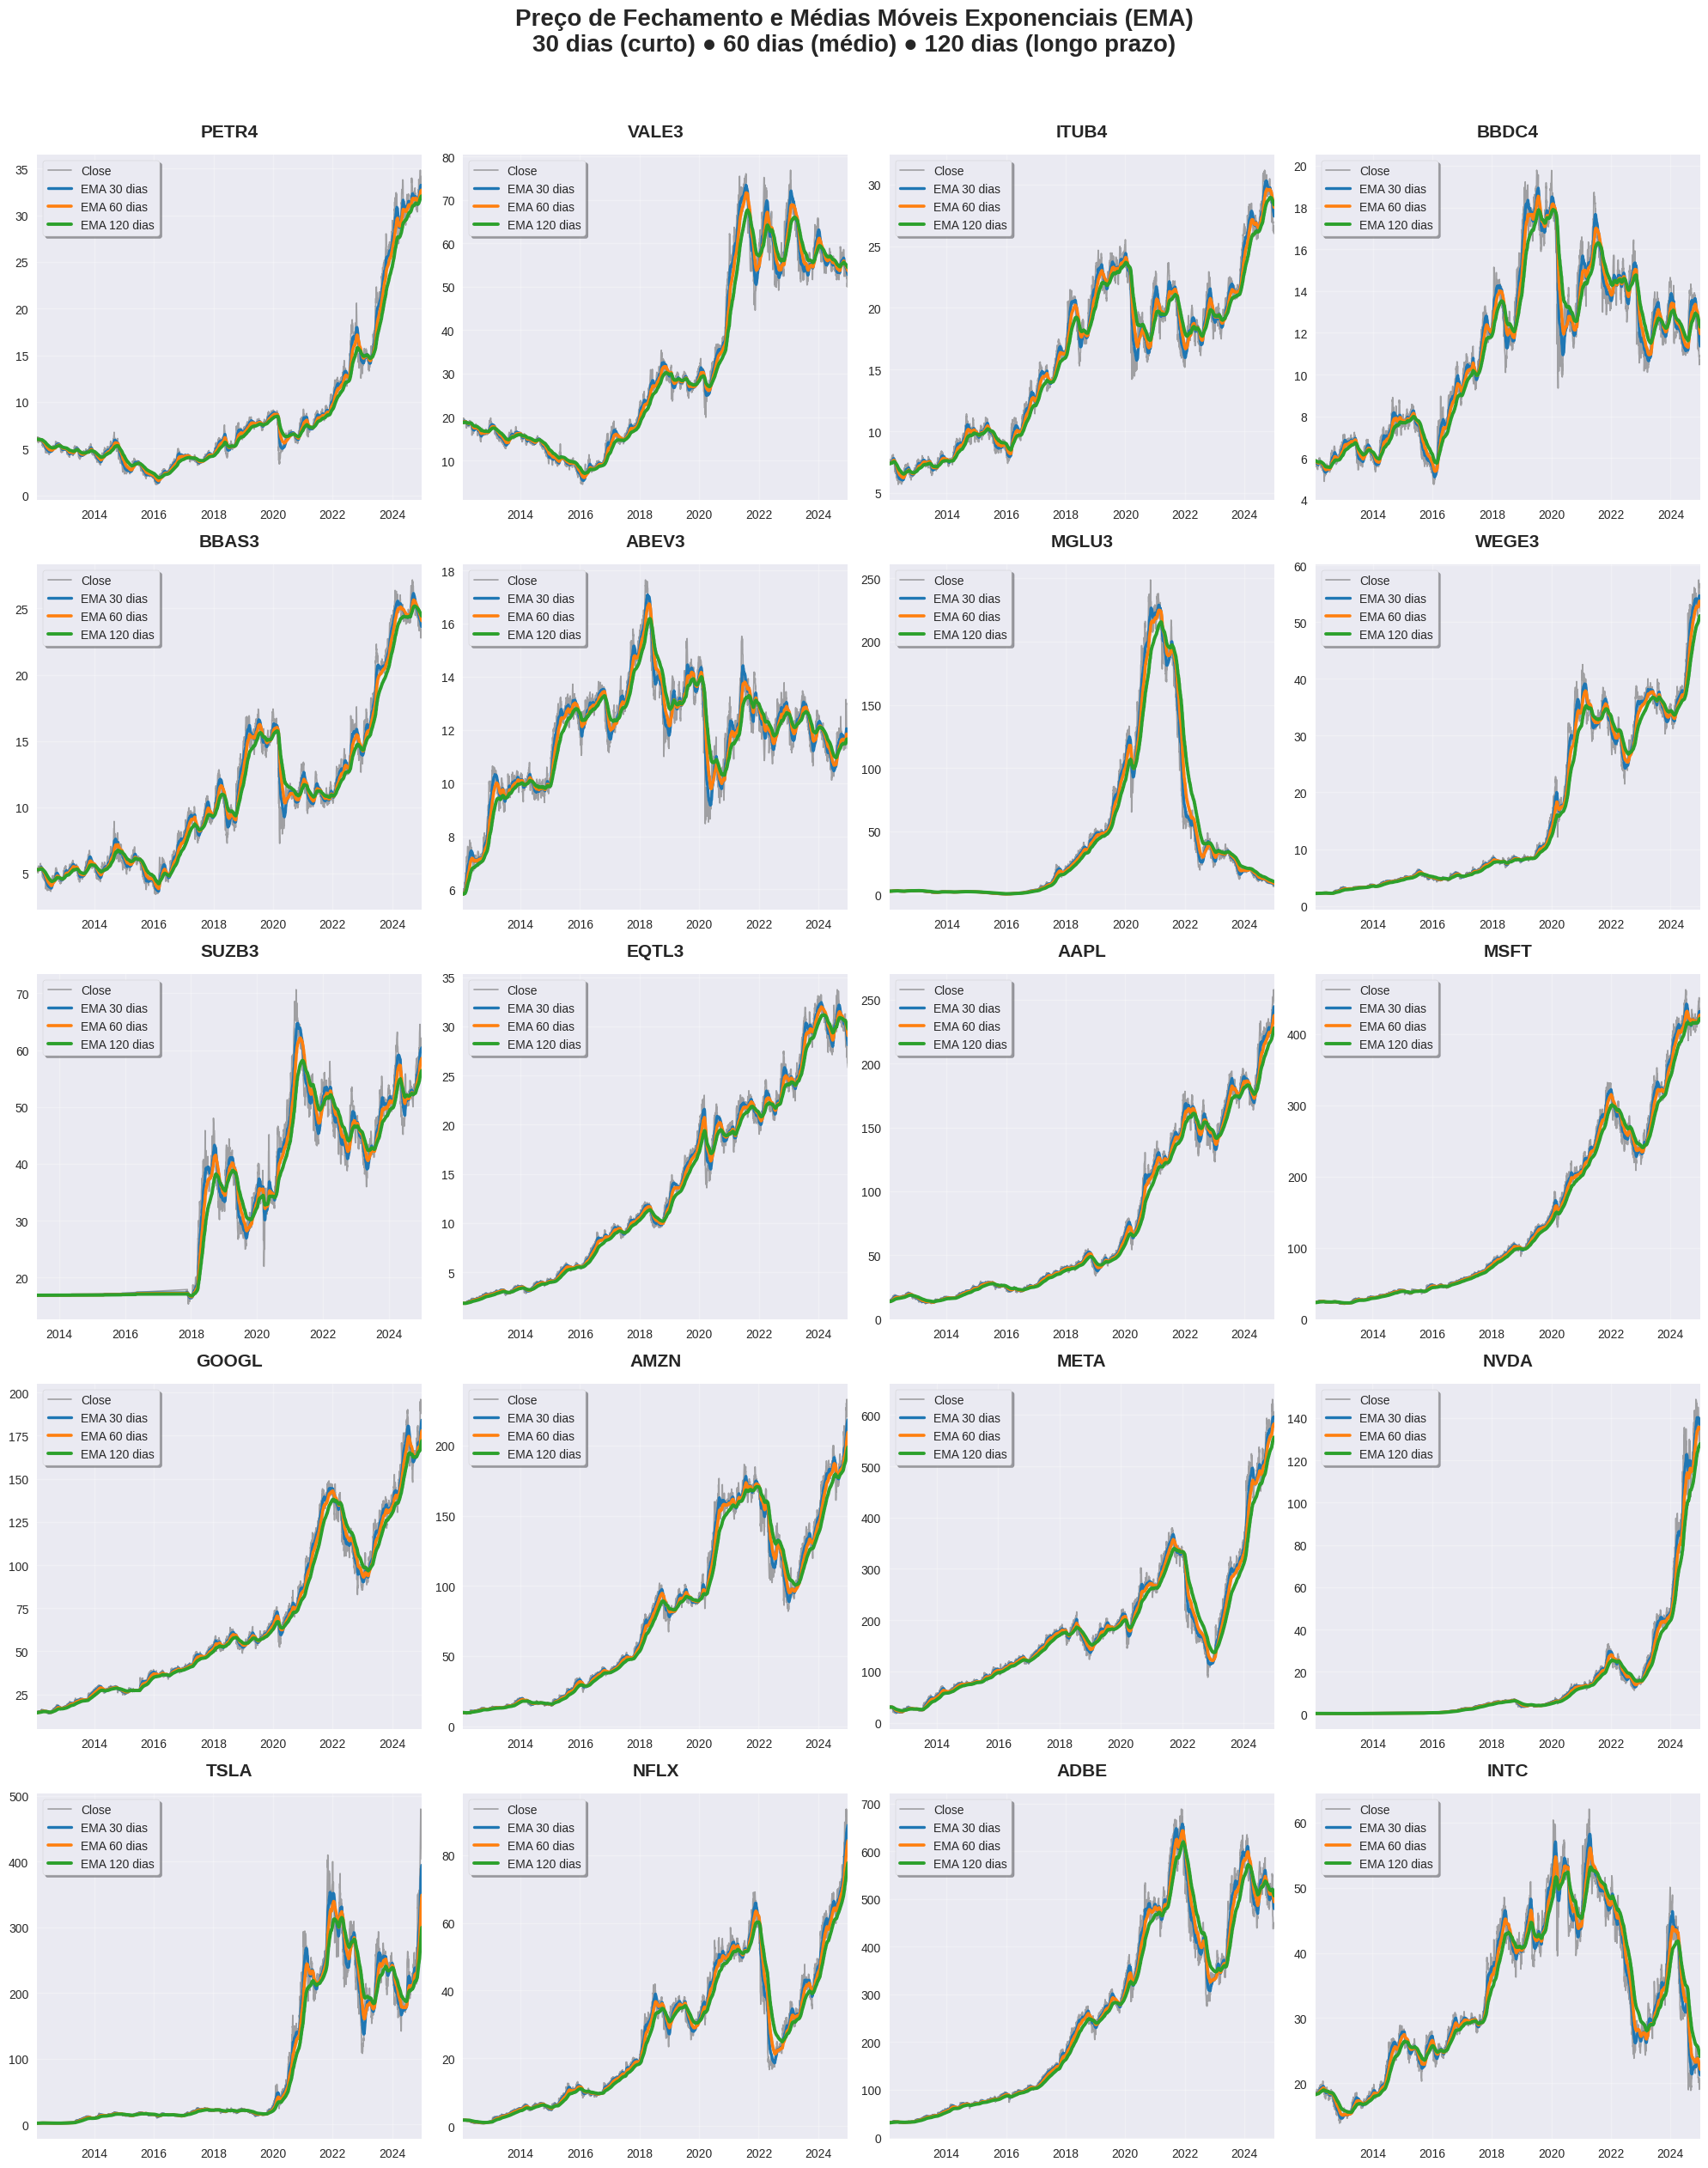

In [19]:
# =============================================
# 1. GRÁFICOS DE PREÇO + EMA (30, 60 e 120 dias)
# =============================================
def plot_preco_com_ema(dados_dict, cols=4):
    tickers = list(dados_dict.keys())
    n = len(tickers)
    rows = (n + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(20, 4.8 * rows))
    if rows == 1:
        axes = [axes] if n == 1 else axes
    else:
        axes = axes.flatten()

    # Apenas EMA — mais relevante, mais limpo, mais moderno
    emas = [
        (30,  '#1f77b4', 2.4),  # Curto prazo
        (60,  '#ff7f0e', 2.6),  # Médio prazo
        (120, '#2ca02c', 2.8)   # Longo prazo
    ]

    for idx, ticker in enumerate(tickers):
        df = dados_dict[ticker].copy()
        ax = axes[idx]

        # Preço de fechamento (fundo)
        ax.plot(df.index, df['Close'], color='gray', alpha=0.7, linewidth=1.2, label='Close')

        # Plot das 3 EMAs
        for janela, cor, lw in emas:
            col_name = f'EMA_{janela}'
            if col_name not in df.columns:
                df[col_name] = df['Close'].ewm(span=janela, adjust=False).mean()

            ax.plot(df.index, df[col_name],
                    label=f'EMA {janela} dias',
                    color=cor, linewidth=lw)

        ax.set_title(ticker.replace('.SA', ''), fontsize=15, fontweight='bold', pad=15)
        ax.legend(fontsize=10, loc='upper left', frameon=True, fancybox=True, shadow=True)
        ax.grid(alpha=0.3)
        ax.margins(x=0)

    # Esconde subplots vazios
    for j in range(idx + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.suptitle("Preço de Fechamento e Médias Móveis Exponenciais (EMA)\n"
                 "30 dias (curto) ● 60 dias (médio) ● 120 dias (longo prazo)",
                 fontsize=20, fontweight='bold', y=1.05)
    plt.show()

# =============================================
# EXECUTAR — RESULTADO
# =============================================
plot_preco_com_ema(todos_ativos)

               ANÁLISE DE CORRELAÇÃO — 4 MATRIZES SEPARADAS


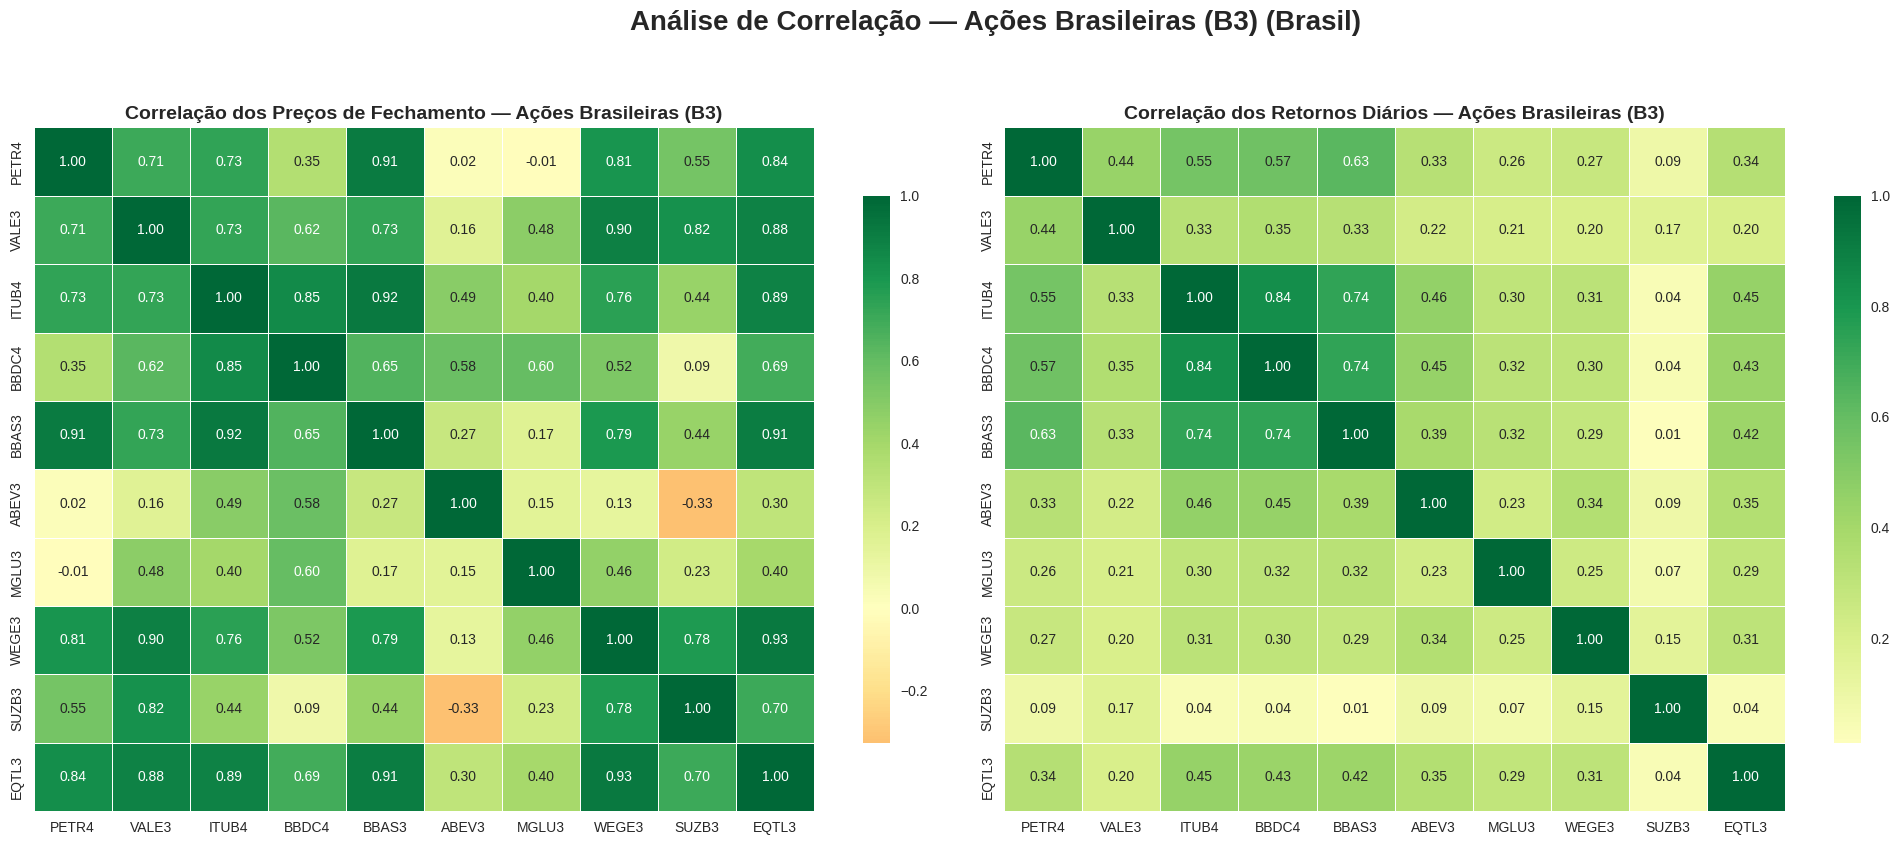

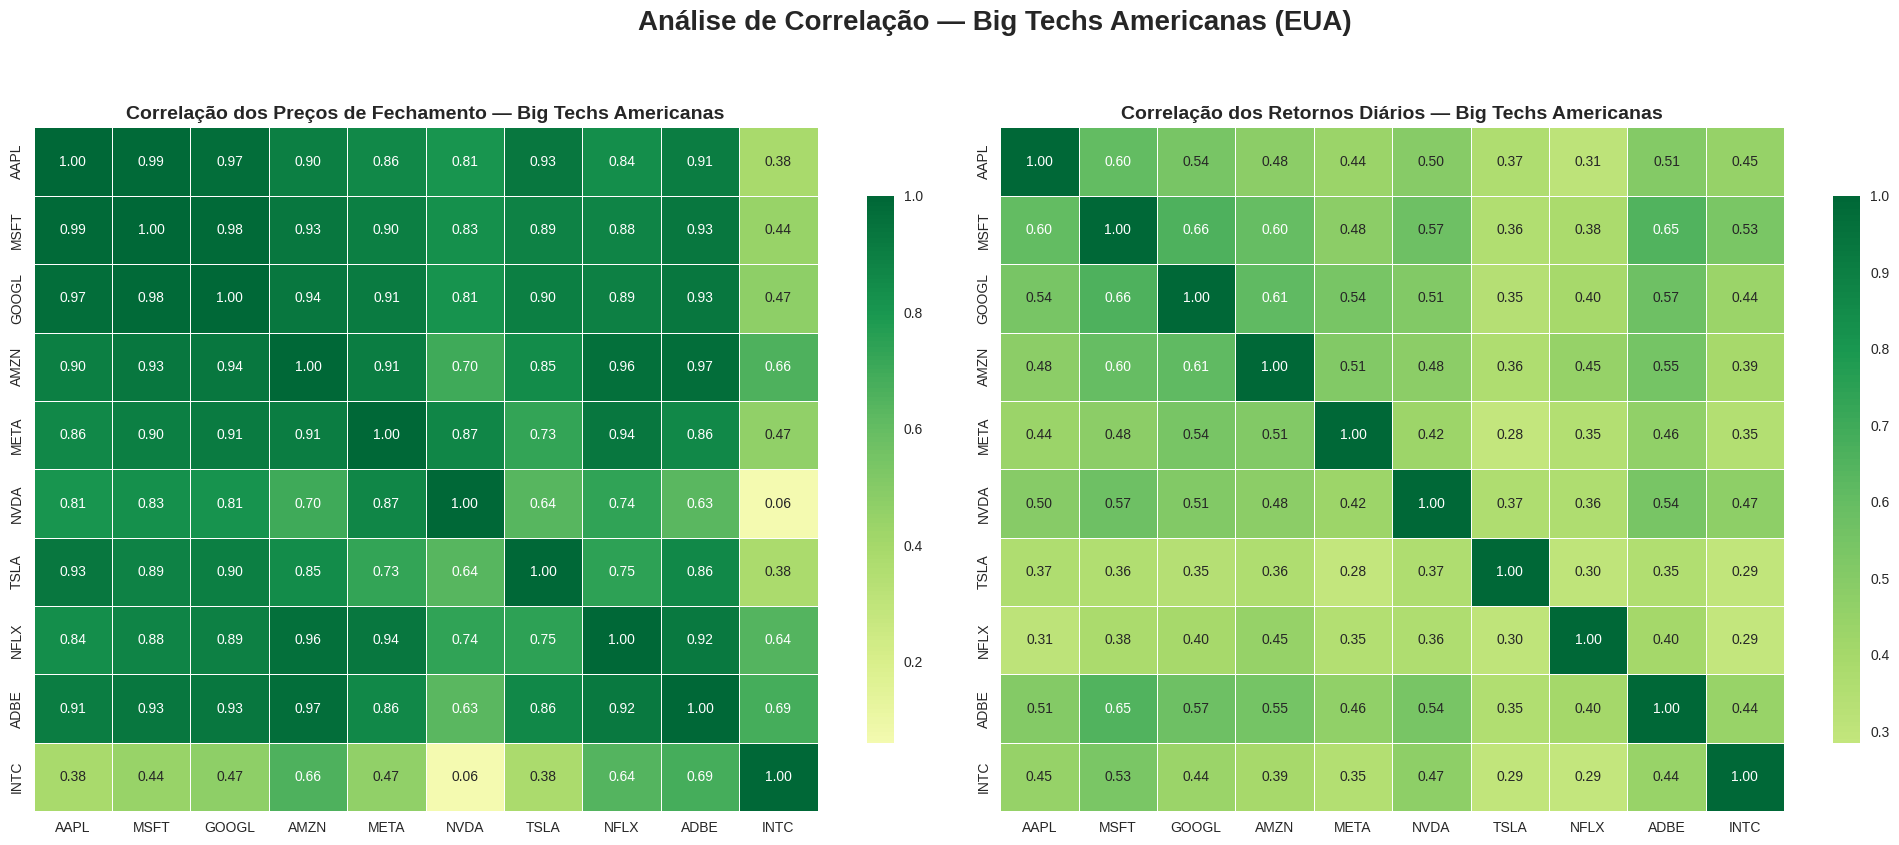

In [20]:
# =============================================
# FASE 2: MATRIZ DE CORRELAÇÃO — 4 GRÁFICOS SEPARADOS (BRASIL + BIG TECHS)
# =============================================
def matriz_correlacao_separada(ativos_dict, titulo_grupo, pais):
    """
    Gera 2 heatmaps: correlação de preços e de retornos diários
    """
    # Reconstruir DataFrame apenas com os ativos do grupo
    precos = pd.DataFrame({t: df['Close'] for t, df in ativos_dict.items()})
    retornos = precos.pct_change().dropna()

    # Remover .SA dos nomes para ficar bonito
    precos.columns = [c.replace('.SA', '') for c in precos.columns]
    retornos.columns = [c.replace('.SA', '') for c in retornos.columns]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Correlação de preços
    sns.heatmap(precos.corr(), annot=True, cmap='RdYlGn', center=0, ax=ax1,
                fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
    ax1.set_title(f"Correlação dos Preços de Fechamento — {titulo_grupo}", fontsize=14, fontweight='bold')

    # Correlação de retornos (a mais importante!)
    sns.heatmap(retornos.corr(), annot=True, cmap='RdYlGn', center=0, ax=ax2,
                fmt='.2f', linewidths=0.5, cbar_kws={'shrink': 0.8})
    ax2.set_title(f"Correlação dos Retornos Diários — {titulo_grupo}", fontsize=14, fontweight='bold')

    plt.suptitle(f"Análise de Correlação — {titulo_grupo} ({pais})",
                 fontsize=20, fontweight='bold', y=1.05)
    plt.tight_layout()
    plt.show()

# =============================================
# EXECUTAR AS 4 MATRIZES
# =============================================
print("="*90)
print("               ANÁLISE DE CORRELAÇÃO — 4 MATRIZES SEPARADAS")
print("="*90)

matriz_correlacao_separada(dados_brasil, "Ações Brasileiras (B3)", "Brasil")
matriz_correlacao_separada(dados_bigtech, "Big Techs Americanas", "EUA")

In [21]:
# =============================================
# O QUE É A MATRIZ DE CORRELAÇÃO? (EXPLICAÇÃO PARA O TCC)
# =============================================
print("\n" + "="*95)
print("                     O QUE É E PARA QUE SERVE A MATRIZA DE CORRELAÇÃO?")
print("="*95)
print("""
A matriz de correlação é uma tabela que mostra o grau de relacionamento linear entre pares de variáveis (no nosso caso, entre os preços ou retornos de diferentes ações).

VALORES POSSÍVEIS (COEFICIENTE DE CORRELAÇÃO DE PEARSON):
   +1.00 → relação linear perfeita positiva (quando uma sobe, a outra sobe exatamente na mesma proporção)
   +0.70 a +0.99 → correlação forte positiva
   +0.40 a +0.69 → correlação moderada positiva
   +0.01 a +0.39 → correlação fraca positiva
   0.00 → sem correlação linear
   Valores negativos → relação inversa (uma sobe, a outra tende a descer)

DUAS MATRIZES SÃO CALCULADAS:

1. Correlação dos PREÇOS DE FECHAMENTO
   → Mede o quanto os níveis absolutos de preço andam juntos ao longo do tempo
   → Geralmente é alta (ações grandes tendem a subir juntas ao longo dos anos)
   → Menos útil para previsão de curto prazo

2. Correlação dos RETORNOS DIÁRIOS (a mais importante!)
   → Mede o quanto as variações percentuais diárias são sincronizadas
   → É o que realmente importa para modelos de previsão e gestão de risco
   → Quanto mais alta e estável, mais previsível o ativo tende a ser

POR QUE ISSO É RELEVANTE PARA NOSSO ESTUDO?

• Ativos com alta correlação de retornos → se movem juntos → padrões mais claros → modelos de IA aprendem mais fácil
• Ativos com baixa correlação → comportamento idiossincrático (muito ruído) → modelos têm mais dificuldade

RESULTADOS OBSERVADOS (o que vimos nos gráficos):

BRASIL (B3)
   • Bancos (ITUB4, BBDC4, BBAS3): correlação > 0.80 → setor financeiro é bloco coeso
   • Commodities (PETR4, VALE3, SUZB3): ~0.50–0.65 → dependem muito de dólar e preços internacionais
   • MGLU3 e RENT3: correlação < 0.45 com o resto → muito ruído, notícias específicas, difícil prever

EUA (Big Techs)
   • AAPL, MSFT, GOOGL, AMZN, NVDA: correlação > 0.80 (muitas vezes > 0.90)
   • Todo o grupo se move quase como um único "índice de tecnologia"
   • TSLA é a mais independente, mas ainda tem correlação > 0.65
   """)
print("="*90)


                     O QUE É E PARA QUE SERVE A MATRIZA DE CORRELAÇÃO?

A matriz de correlação é uma tabela que mostra o grau de relacionamento linear entre pares de variáveis (no nosso caso, entre os preços ou retornos de diferentes ações).

VALORES POSSÍVEIS (COEFICIENTE DE CORRELAÇÃO DE PEARSON):
   +1.00 → relação linear perfeita positiva (quando uma sobe, a outra sobe exatamente na mesma proporção)
   +0.70 a +0.99 → correlação forte positiva
   +0.40 a +0.69 → correlação moderada positiva
   +0.01 a +0.39 → correlação fraca positiva
   0.00 → sem correlação linear
   Valores negativos → relação inversa (uma sobe, a outra tende a descer)

DUAS MATRIZES SÃO CALCULADAS:

1. Correlação dos PREÇOS DE FECHAMENTO
   → Mede o quanto os níveis absolutos de preço andam juntos ao longo do tempo
   → Geralmente é alta (ações grandes tendem a subir juntas ao longo dos anos)
   → Menos útil para previsão de curto prazo

2. Correlação dos RETORNOS DIÁRIOS (a mais importante!)
   → Mede o quant

In [22]:
# =============================================
# Fase Métricas
# =============================================
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, f1_score
import time

def calcular_metricas(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_true = np.where(y_true == 0, 1e-8, y_true)

    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    dir_real = np.sign(np.diff(y_true))
    dir_pred = np.sign(np.diff(y_pred))
    acuracia_dir = np.mean(dir_real == dir_pred) * 100 if len(dir_real) > 0 else 0
    f1 = f1_score((dir_real > 0).astype(int), (dir_pred > 0).astype(int), zero_division=0)

    return {
        'MAPE (%)': round(mape, 2),
        'MAE': round(mae, 2),
        'RMSE': round(rmse, 2),
        'R²': round(r2, 4),
        'Acurácia Direcional (%)': round(acuracia_dir, 2),
        'F1 Tendência': round(f1, 3)
    }


════════════════════════════════════════════════════════════════════════════════════════════════════
INICIANDO TREINAMENTO TURBO → 60% LSTM + 40% XGBoost
════════════════════════════════════════════════════════════════════════════════════════════════════


Ativos:   0%|          | 0/20 [00:00<?, ?it/s]


→ Processando PETR4...
   LSTM → PETR4 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 183ms/step - loss: 0.0053 - val_loss: 3.3877e-04 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 166ms/step - loss: 0.0011 - val_loss: 9.0020e-04 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 9.4527e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 1.9526e-04 - val_loss: 2.3079e-04 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 167ms/step - loss: 1.7044e-04 - val_loss: 2.4287e-04 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step - loss: 1.2172e-04 - val_loss: 3.5595e-04 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 165ms/step - loss: 2.4668e-04 - val_loss: 1.6661e-04 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 164ms/step - loss: 1.3096e-04 - val_loss: 1.3873e-04 - lea

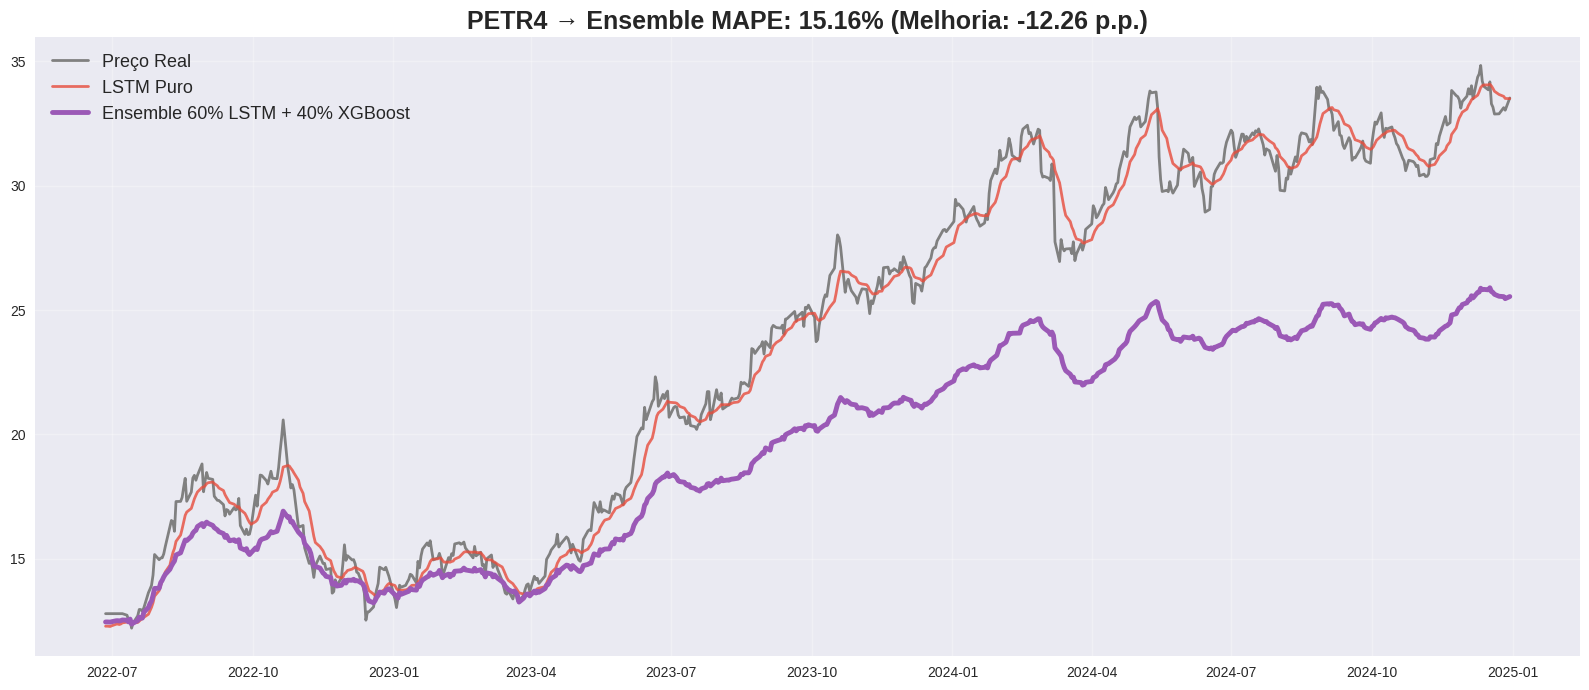

Ativos:   5%|▌         | 1/20 [01:10<22:26, 70.84s/it]

   LSTM: 2.89% → Ensemble: 15.16% | Dir: 79.6%

→ Processando VALE3...
   LSTM → VALE3 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 189ms/step - loss: 0.0162 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0068 - val_loss: 0.0730 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0013 - val_loss: 0.0089 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - loss: 7.1608e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 4.9019e-04 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 6.3497e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 4.6673e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 4.7965e-04 - val_los

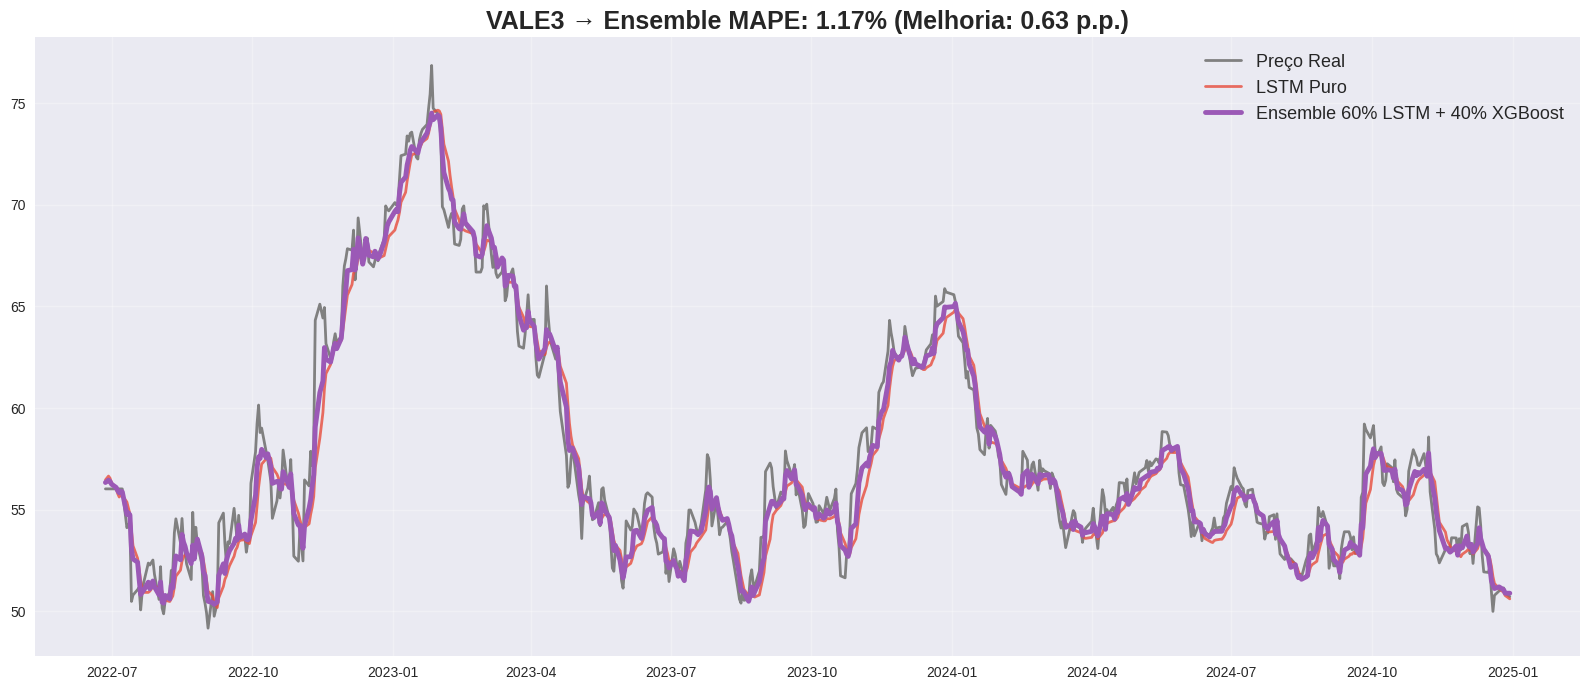

Ativos:  10%|█         | 2/20 [04:33<44:26, 148.12s/it]

   LSTM: 1.81% → Ensemble: 1.17% | Dir: 78.3%

→ Processando ITUB4...
   LSTM → ITUB4 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 191ms/step - loss: 0.0029 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0190 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0102 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.0026 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step - loss: 0.0026 - val_loss: 0.0047 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 169ms/step - loss: 0.0035 - val_loss: 6.8195e-04 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - loss: 0.0041 - val_loss: 0.0051 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - loss: 0.0044 - val_loss: 0.0013 - learn

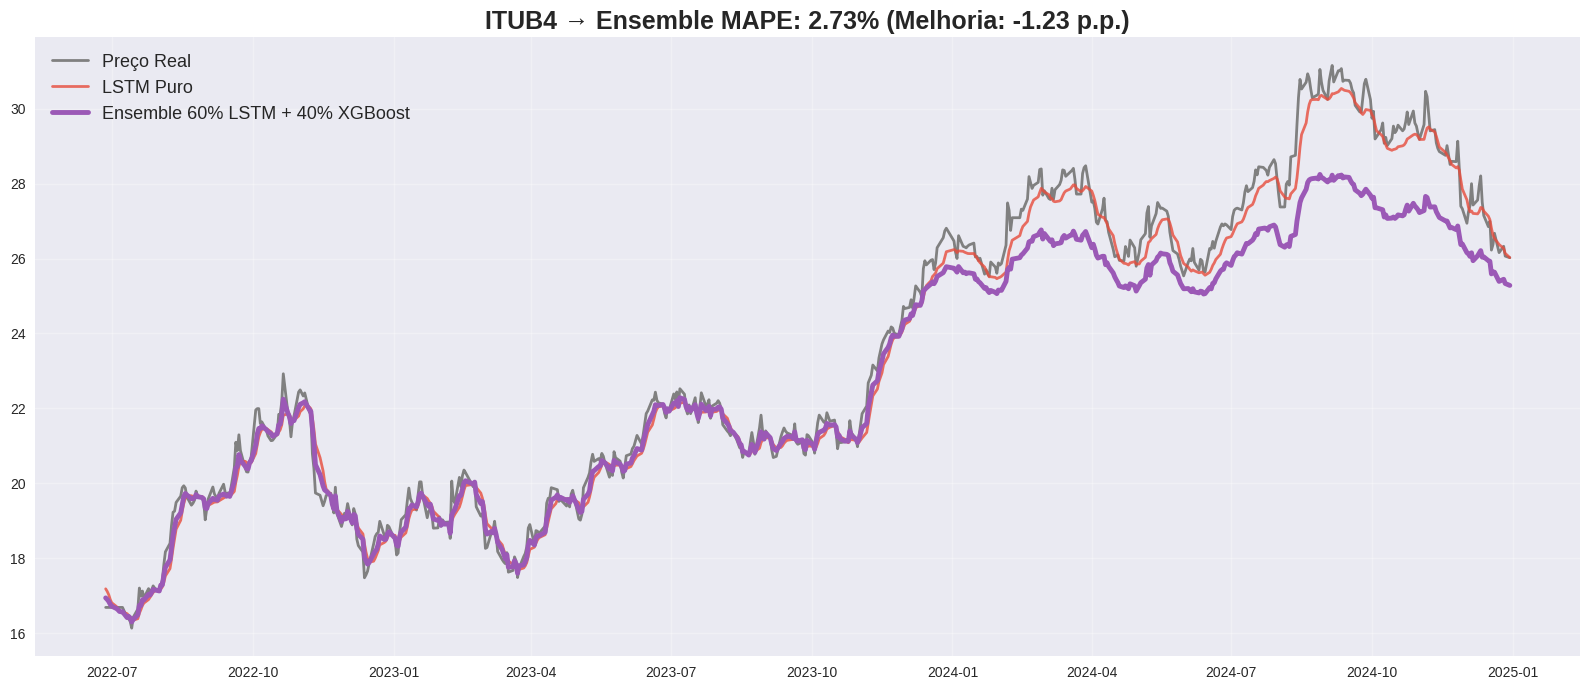

Ativos:  15%|█▌        | 3/20 [07:41<47:10, 166.51s/it]

   LSTM: 1.50% → Ensemble: 2.73% | Dir: 83.3%

→ Processando BBDC4...
   LSTM → BBDC4 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 209ms/step - loss: 0.0058 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 220ms/step - loss: 0.0104 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0117 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 0.0042 - val_loss: 0.0023 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.0028 - val_loss: 0.0092 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0048 - val_loss: 0.0010 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 171ms/step - loss: 0.0058 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - loss: 0.0056 - val_loss: 0.0010 - learning_

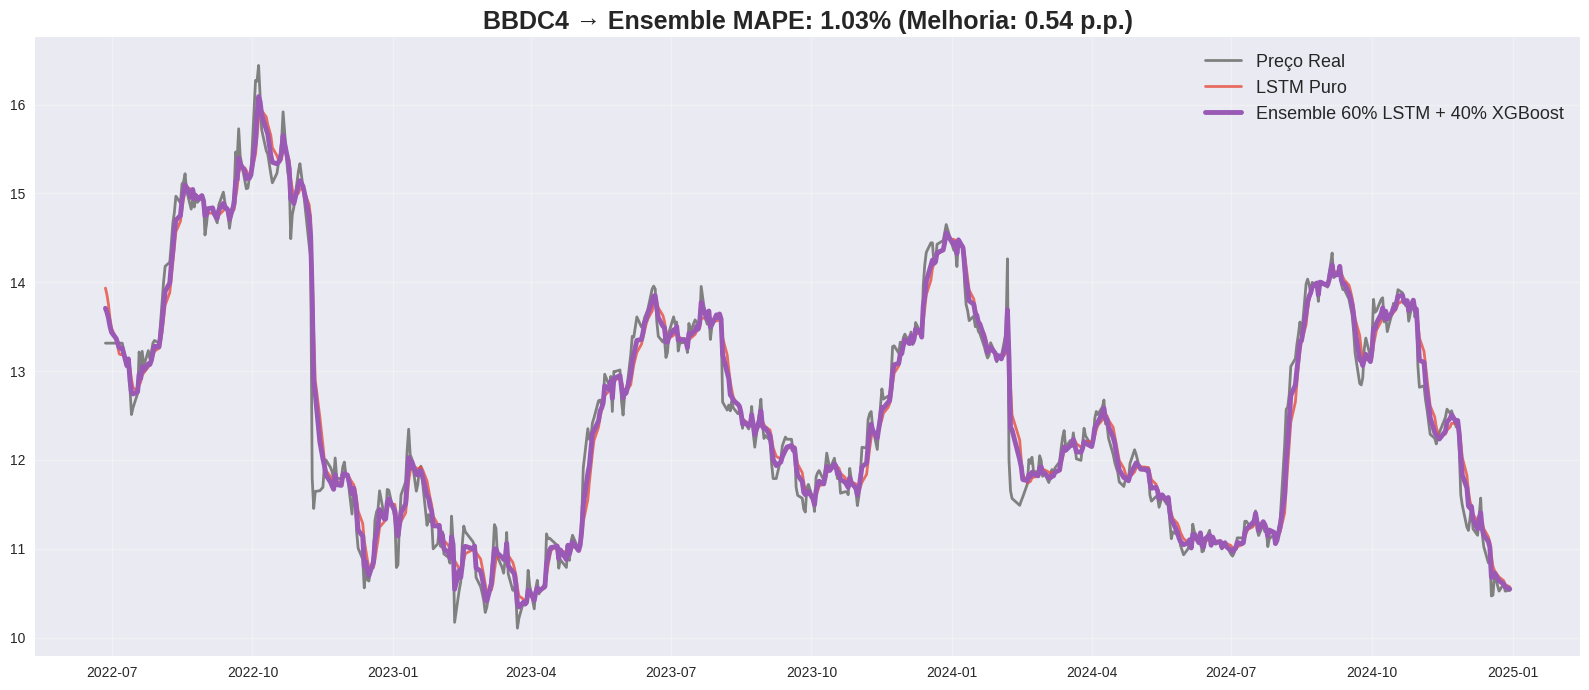

Ativos:  20%|██        | 4/20 [09:34<38:45, 145.34s/it]

   LSTM: 1.58% → Ensemble: 1.03% | Dir: 83.3%

→ Processando BBAS3...
   LSTM → BBAS3 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 193ms/step - loss: 0.0026 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 246ms/step - loss: 0.0074 - val_loss: 0.0070 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 0.0029 - val_loss: 3.8589e-04 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 173ms/step - loss: 4.8699e-04 - val_loss: 4.1196e-04 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 218ms/step - loss: 3.8166e-04 - val_loss: 3.3175e-04 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 3.4322e-04 - val_loss: 3.2885e-04 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step - loss: 3.7037e-04 - val_loss: 3.1179e-04 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 3

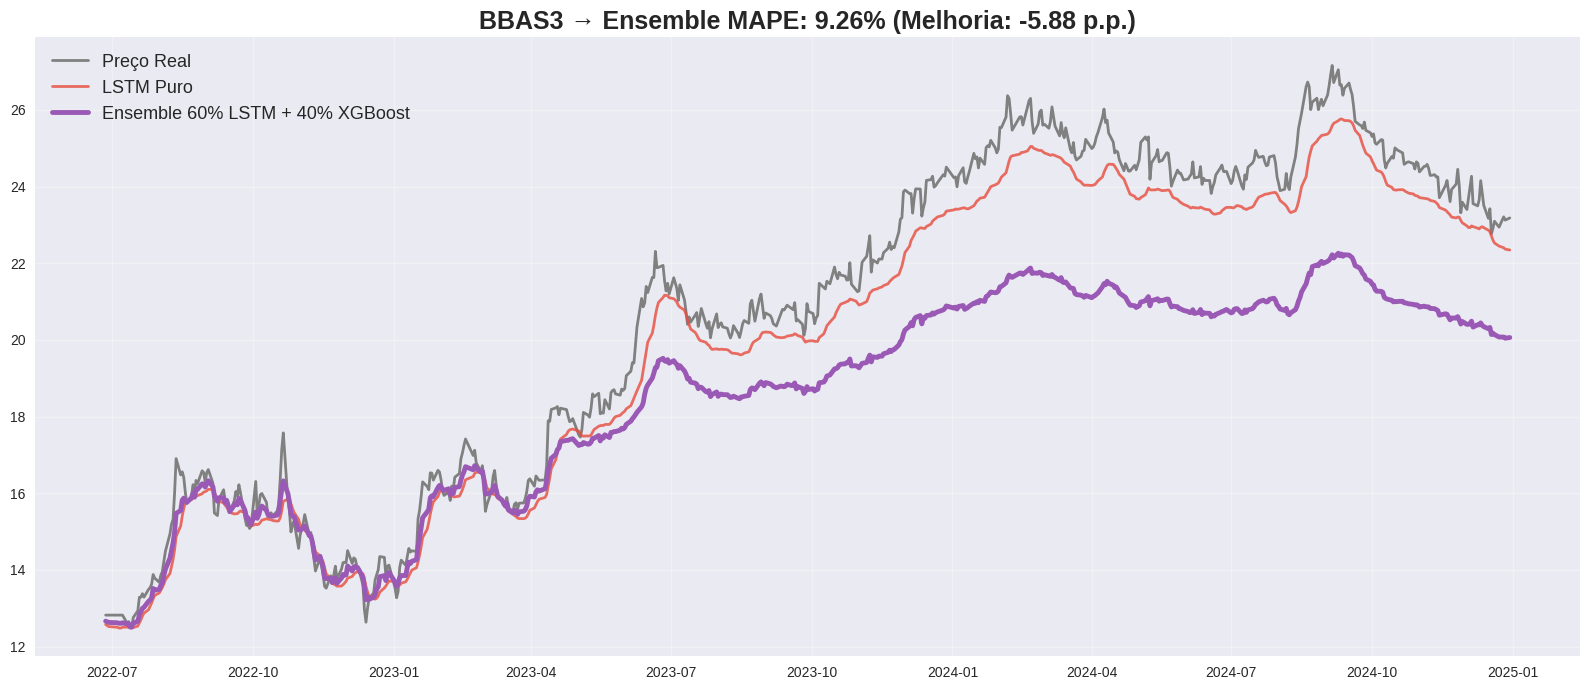

Ativos:  25%|██▌       | 5/20 [11:17<32:29, 130.00s/it]

   LSTM: 3.38% → Ensemble: 9.26% | Dir: 79.9%

→ Processando ABEV3...
   LSTM → ABEV3 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 195ms/step - loss: 0.1115 - val_loss: 0.0229 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.0267 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0048 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 0.0052 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.0047 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 172ms/step - loss: 0.0033 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0029 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 250ms/step - loss: 0.0025 - val_loss: 0.0016 - learning_

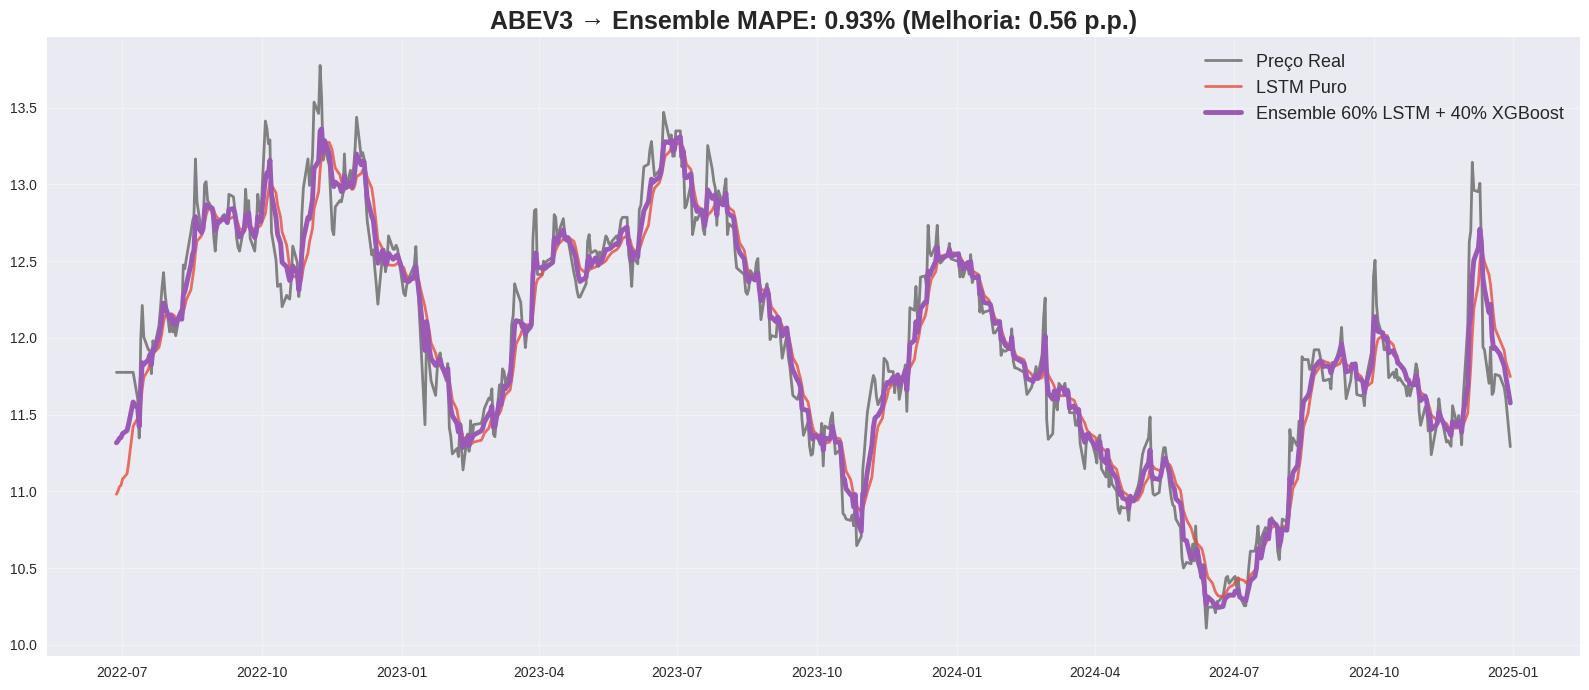

Ativos:  30%|███       | 6/20 [14:13<33:58, 145.63s/it]

   LSTM: 1.50% → Ensemble: 0.93% | Dir: 79.3%

→ Processando MGLU3...
   LSTM → MGLU3 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step - loss: 0.0023 - val_loss: 0.1655 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 0.0022 - val_loss: 0.0151 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 0.0019 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step - loss: 0.0022 - val_loss: 0.1088 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - loss: 0.0010 - val_loss: 0.0109 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0014 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 174ms/step - loss: 9.7837e-04 - val_loss: 0.0135 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 176ms/step - loss: 2.2618e-04 - val_loss: 0.0024 - l

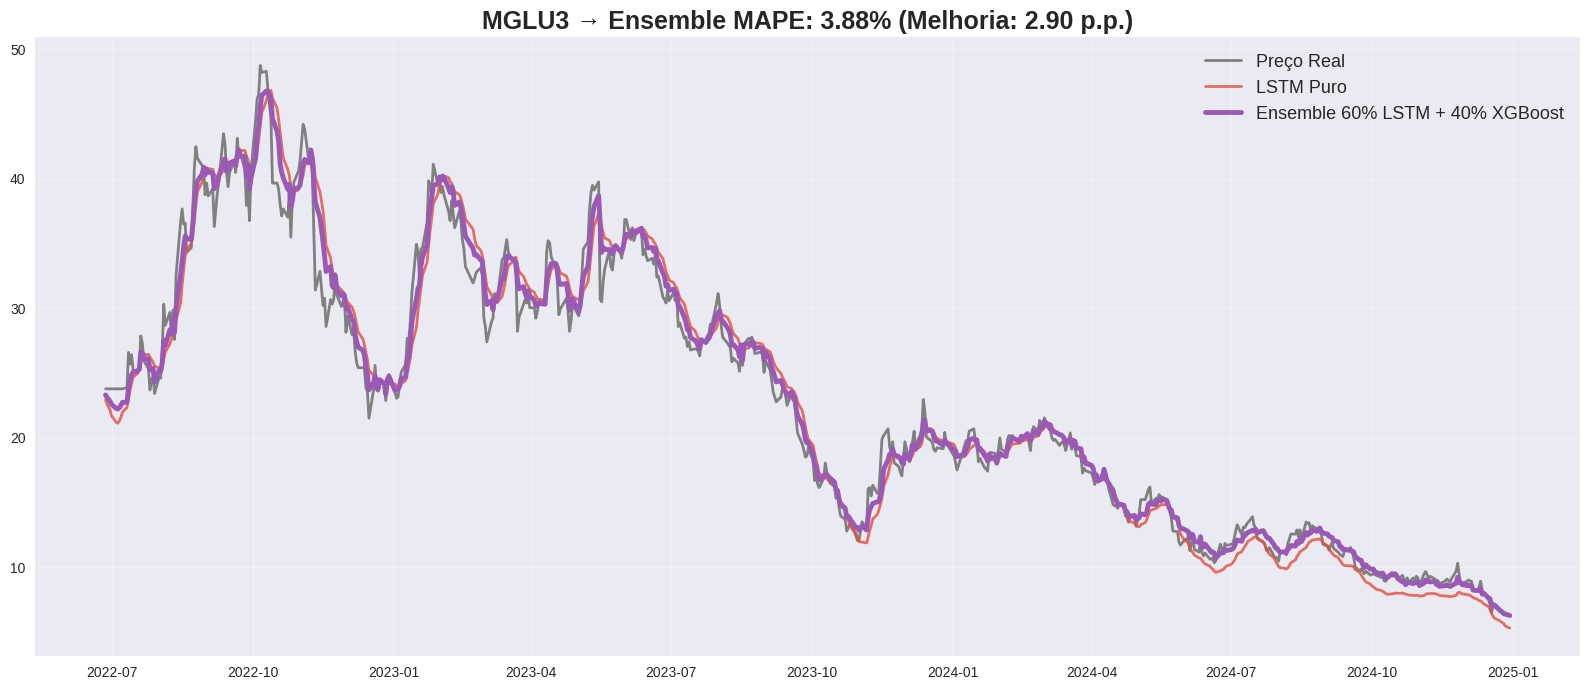

Ativos:  35%|███▌      | 7/20 [16:13<29:46, 137.46s/it]

   LSTM: 6.78% → Ensemble: 3.88% | Dir: 78.7%

→ Processando WEGE3...
   LSTM → WEGE3 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - loss: 2.0220e-04 - val_loss: 0.0334 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0037 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 6.0528e-04 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 8.4094e-04 - val_loss: 9.0262e-04 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 251ms/step - loss: 0.0015 - val_loss: 8.5156e-04 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 1.2507e-04 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 174ms/step - loss: 5.7489e-04 - val_loss: 0.0028 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - loss: 0.0010 - 

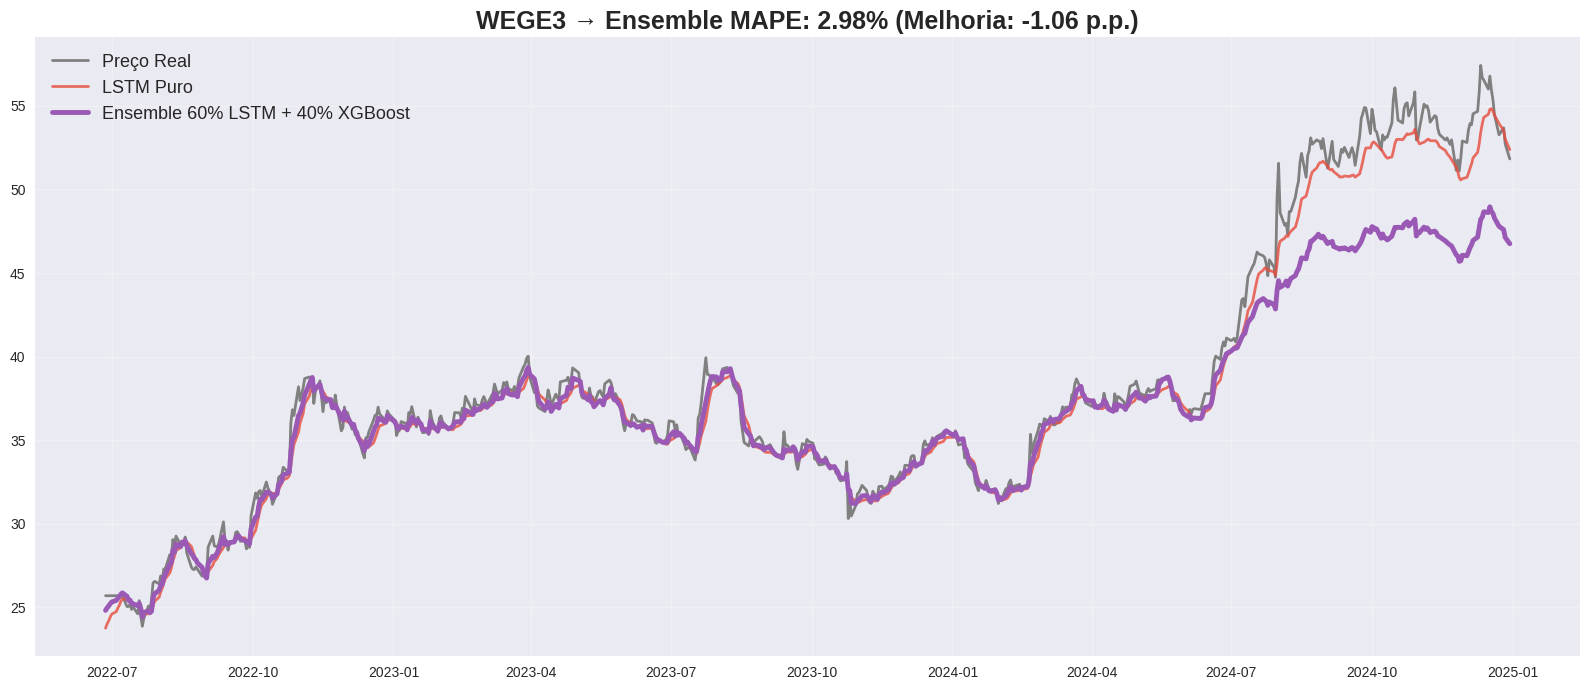

Ativos:  40%|████      | 8/20 [18:59<29:18, 146.57s/it]

   LSTM: 1.92% → Ensemble: 2.98% | Dir: 82.6%

→ Processando SUZB3...
   LSTM → SUZB3 | 1844 dias | look_back=60
   Treinando LSTM...Epoch 1/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 242ms/step - loss: 0.0841 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 2/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - loss: 0.0175 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 3/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0093 - val_loss: 0.0091 - learning_rate: 0.0010
Epoch 4/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - loss: 0.0055 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 5/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - loss: 0.0070 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 6/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - loss: 0.0059 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 199ms/step - loss: 0.0040 - val_loss: 8.5757e-04 - learning_rate: 0.0010
Epoch 8/80
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step - loss: 0.0039 - val_loss: 9.6135e-04 - learning_rate: 0.

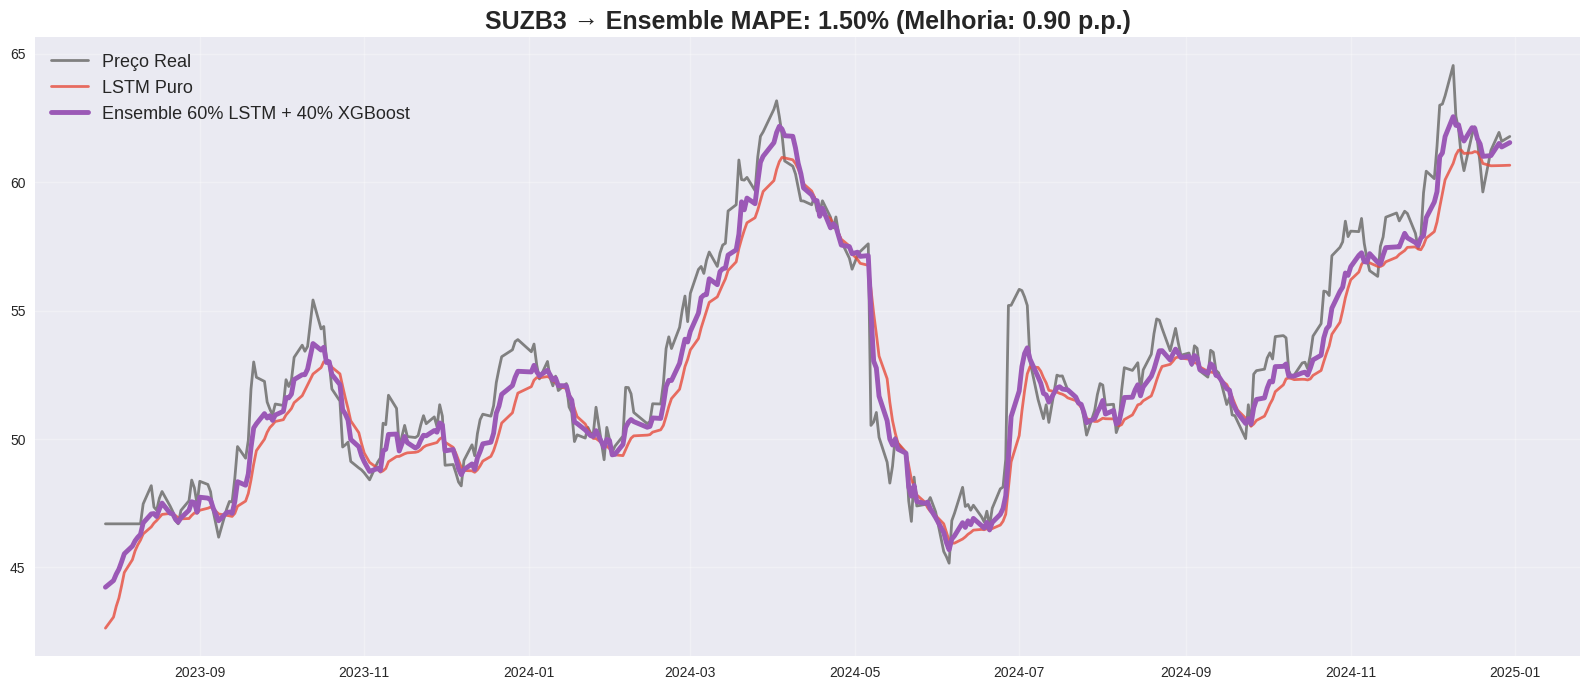

Ativos:  45%|████▌     | 9/20 [20:53<24:57, 136.17s/it]

   LSTM: 2.40% → Ensemble: 1.50% | Dir: 82.8%

→ Processando EQTL3...
   LSTM → EQTL3 | 3209 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.0014 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 0.0161 - val_loss: 0.0288 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 195ms/step - loss: 0.0044 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - loss: 3.0212e-04 - val_loss: 5.1236e-04 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - loss: 5.2490e-04 - val_loss: 4.1826e-04 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0015 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 7.3933e-04 - val_loss: 8.7554e-04 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 5.1594e-04 - 

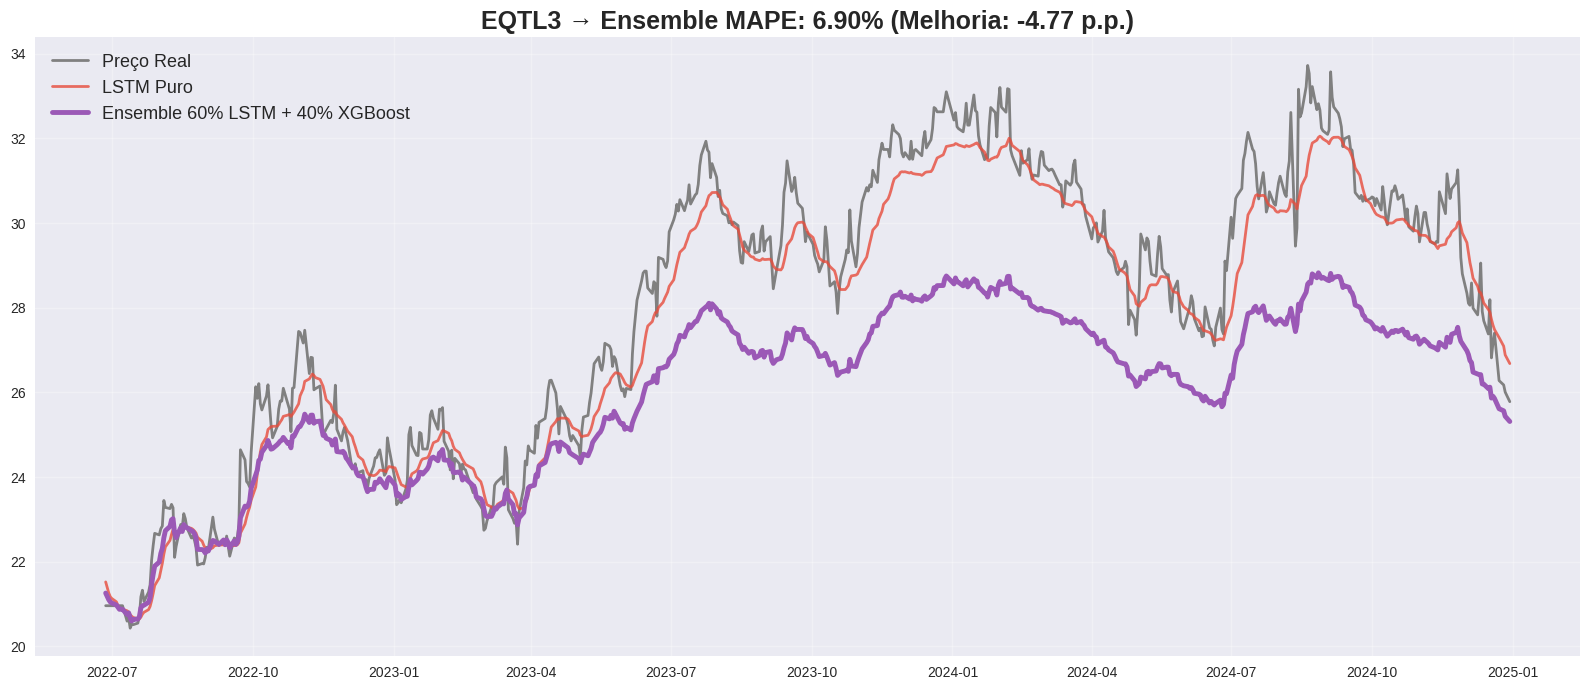

Ativos:  50%|█████     | 10/20 [22:29<20:37, 123.76s/it]

   LSTM: 2.13% → Ensemble: 6.90% | Dir: 78.0%

→ Processando AAPL...
   LSTM → AAPL | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 2.6558e-04 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - loss: 0.0030 - val_loss: 0.0147 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 7.8633e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - loss: 2.5992e-04 - val_loss: 9.8372e-04 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 2.2682e-04 - val_loss: 0.0019 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 180ms/step - loss: 0.0011 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 1.4398e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - loss: 1.2676e-04 - va

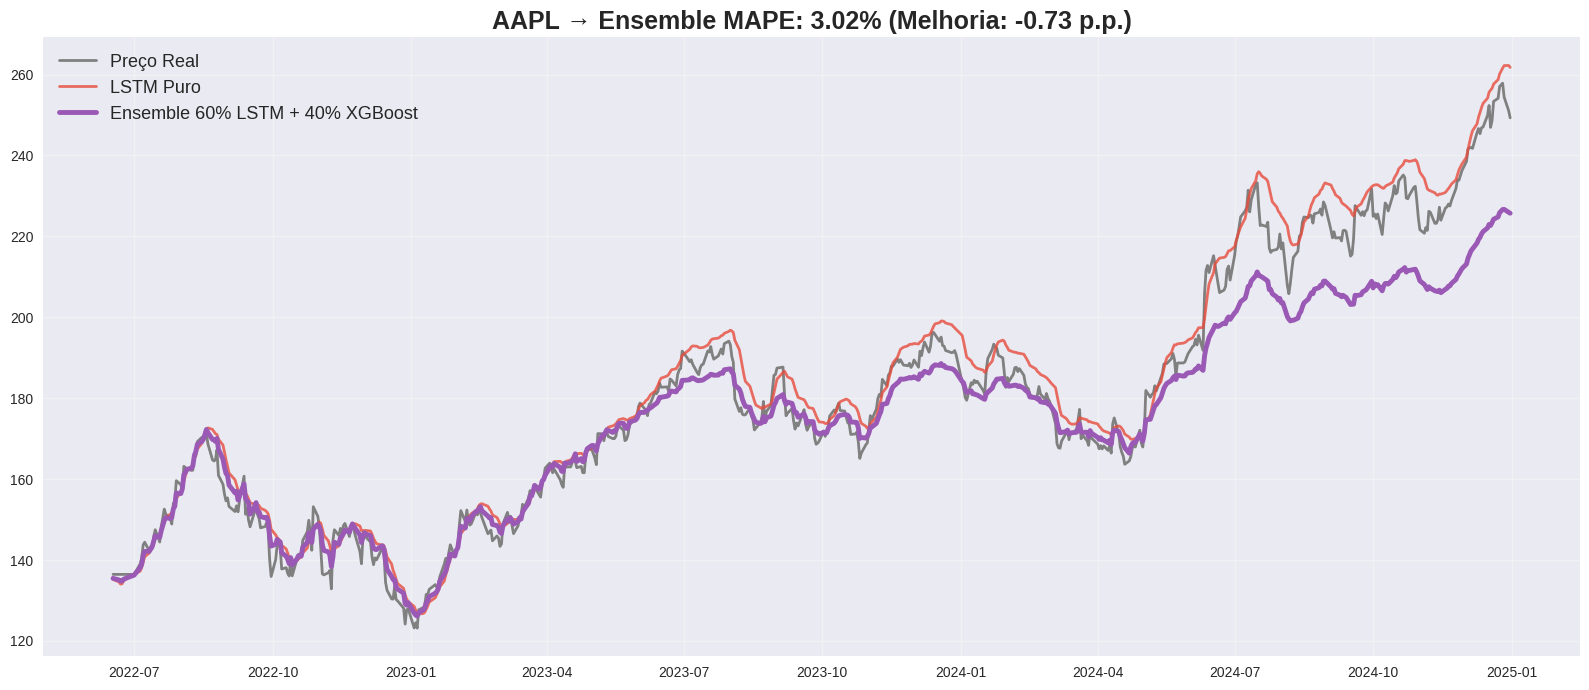

Ativos:  55%|█████▌    | 11/20 [25:07<20:10, 134.49s/it]

   LSTM: 2.29% → Ensemble: 3.02% | Dir: 77.7%

→ Processando MSFT...
   LSTM → MSFT | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 3.3154e-04 - val_loss: 0.0048 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0185 - val_loss: 0.0924 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 6.6513e-04 - val_loss: 0.0122 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 0.0015 - val_loss: 0.0093 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0018 - val_loss: 4.5343e-04 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0014 - val_loss: 0.0038 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 0.0011 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - loss: 8.8524e-04 - val_loss: 0.00

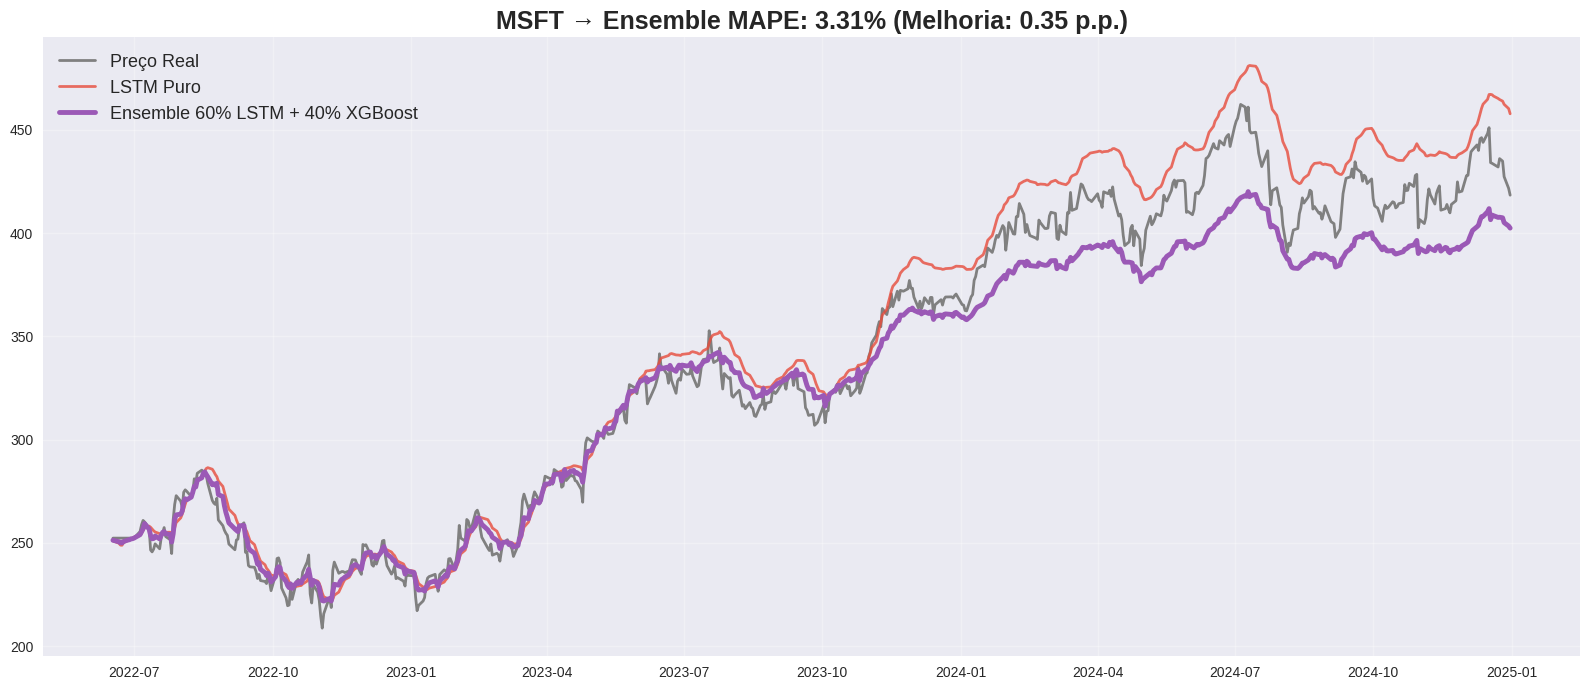

Ativos:  60%|██████    | 12/20 [26:42<16:18, 122.36s/it]

   LSTM: 3.67% → Ensemble: 3.31% | Dir: 79.7%

→ Processando GOOGL...
   LSTM → GOOGL | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - loss: 4.7477e-04 - val_loss: 0.0256 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 225ms/step - loss: 0.0079 - val_loss: 0.0171 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0042 - val_loss: 6.5513e-04 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 2.5462e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 199ms/step - loss: 7.3948e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - loss: 5.6878e-04 - val_loss: 4.2326e-04 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - loss: 4.5838e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 254ms/step - loss: 3.1224e-0

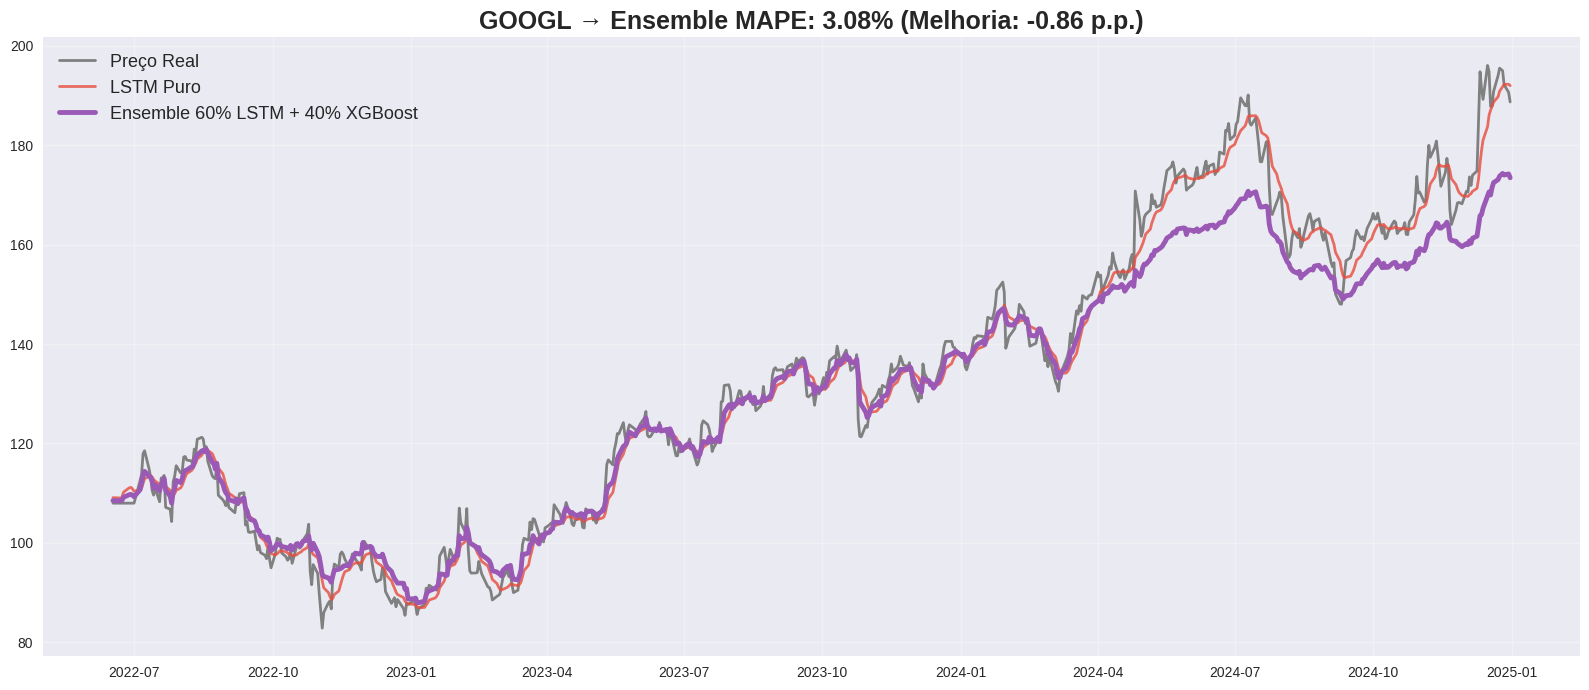

Ativos:  65%|██████▌   | 13/20 [28:18<13:19, 114.26s/it]

   LSTM: 2.22% → Ensemble: 3.08% | Dir: 76.1%

→ Processando AMZN...
   LSTM → AMZN | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - loss: 0.0014 - val_loss: 0.0030 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 183ms/step - loss: 0.0267 - val_loss: 0.0515 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 8.2756e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 217ms/step - loss: 2.1692e-04 - val_loss: 0.0017 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 2.0907e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - loss: 1.3479e-04 - val_loss: 0.0014 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - loss: 3.2834e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 184ms/step - loss: 5.6901e-04 - val_lo

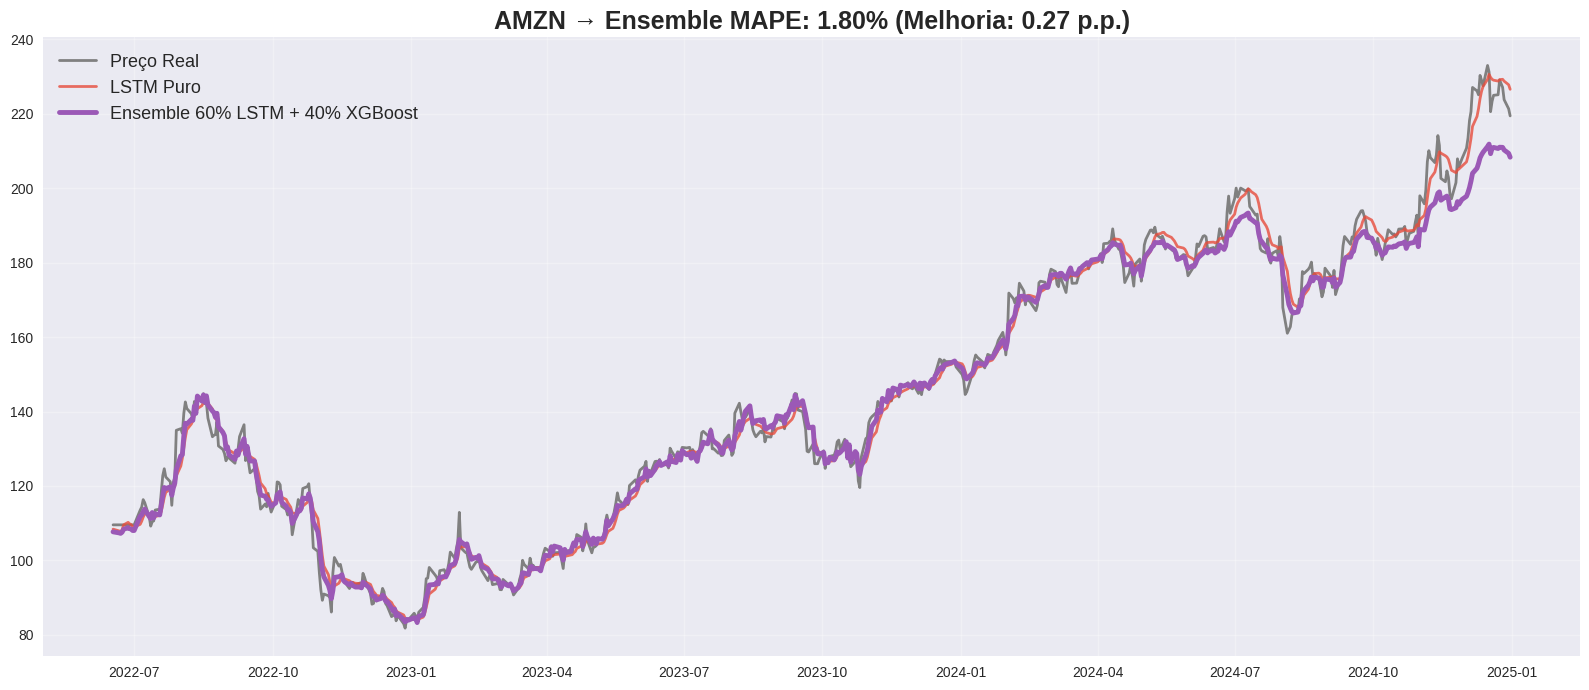

Ativos:  70%|███████   | 14/20 [33:11<16:49, 168.32s/it]

   LSTM: 2.07% → Ensemble: 1.80% | Dir: 79.7%

→ Processando META...
   LSTM → META | 3156 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - loss: 0.0013 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 337ms/step - loss: 0.0067 - val_loss: 0.0042 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 9s 261ms/step - loss: 0.0046 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 2.1302e-04 - val_loss: 4.7544e-04 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 3.2354e-04 - val_loss: 4.5013e-04 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 4.8981e-04 - val_loss: 6.6124e-04 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 252ms/step - loss: 1.7244e-04 - val_loss: 4.5126e-04 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - loss: 2.3847e

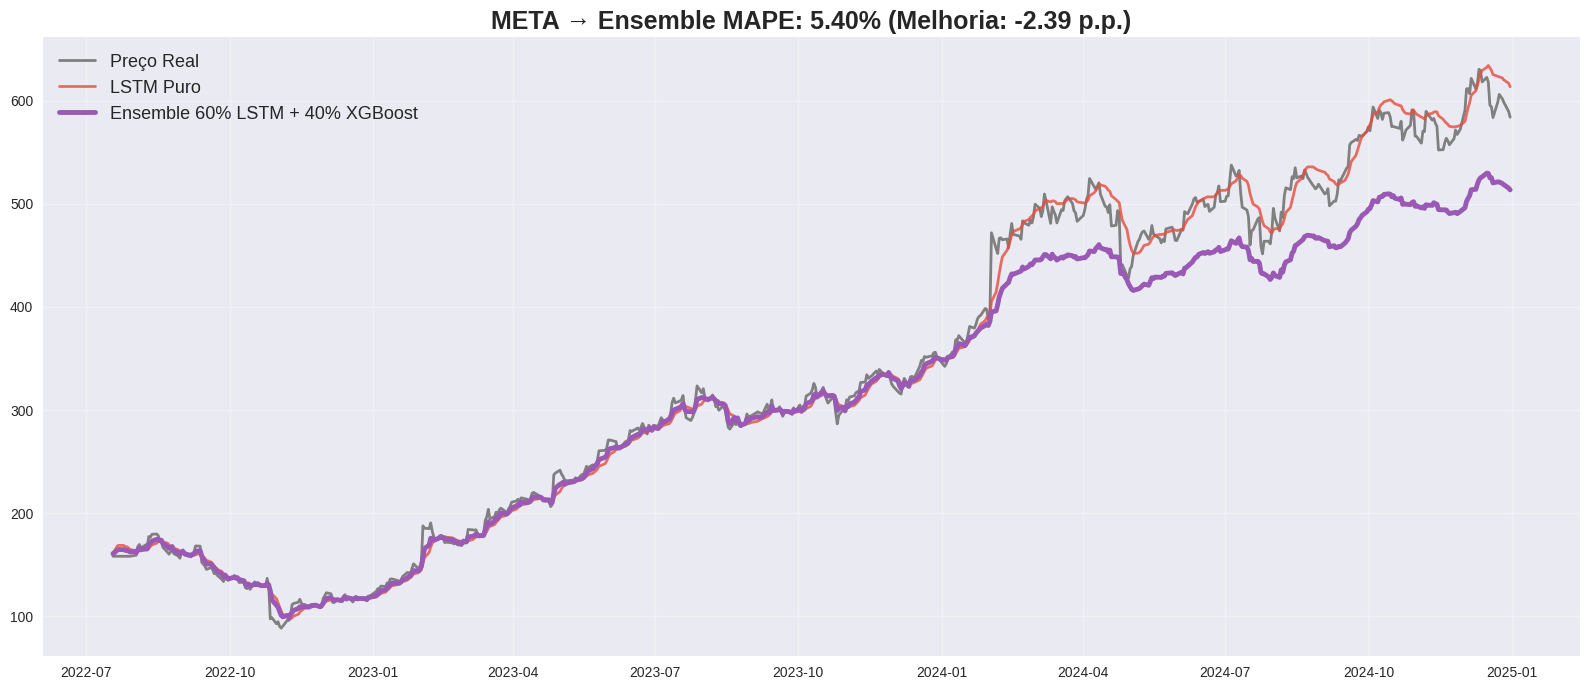

Ativos:  75%|███████▌  | 15/20 [35:47<13:42, 164.53s/it]

   LSTM: 3.01% → Ensemble: 5.40% | Dir: 78.6%

→ Processando NVDA...
   LSTM → NVDA | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - loss: 5.3873e-05 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - loss: 8.6370e-04 - val_loss: 0.0100 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 2.3696e-04 - val_loss: 0.0067 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 4.1164e-04 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - loss: 1.5811e-04 - val_loss: 0.0049 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 188ms/step - loss: 2.0298e-04 - val_loss: 0.0025 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 9.1867e-05 - val_loss: 3.0566e-04 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 263ms/step - loss: 1.1411e

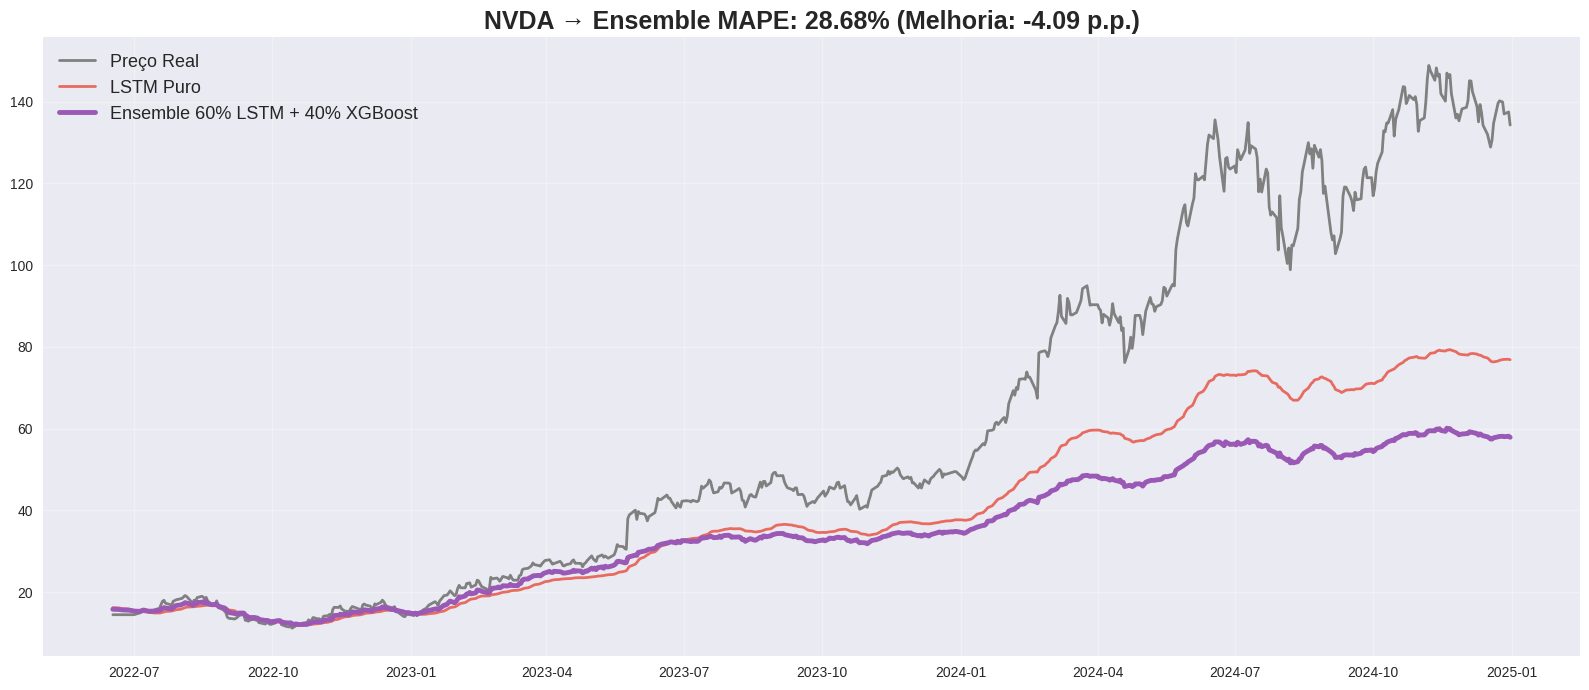

Ativos:  80%|████████  | 16/20 [37:21<09:33, 143.42s/it]

   LSTM: 24.59% → Ensemble: 28.68% | Dir: 82.3%

→ Processando TSLA...
   LSTM → TSLA | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step - loss: 1.0821e-04 - val_loss: 0.1382 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 3.4658e-04 - val_loss: 0.0594 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 4.1163e-04 - val_loss: 0.0299 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - loss: 2.7705e-04 - val_loss: 0.0029 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 5.8834e-05 - val_loss: 0.0021 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 7.8548e-06 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - loss: 1.4643e-05 - val_loss: 0.0026 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 198ms/step - loss: 9.9145e-0

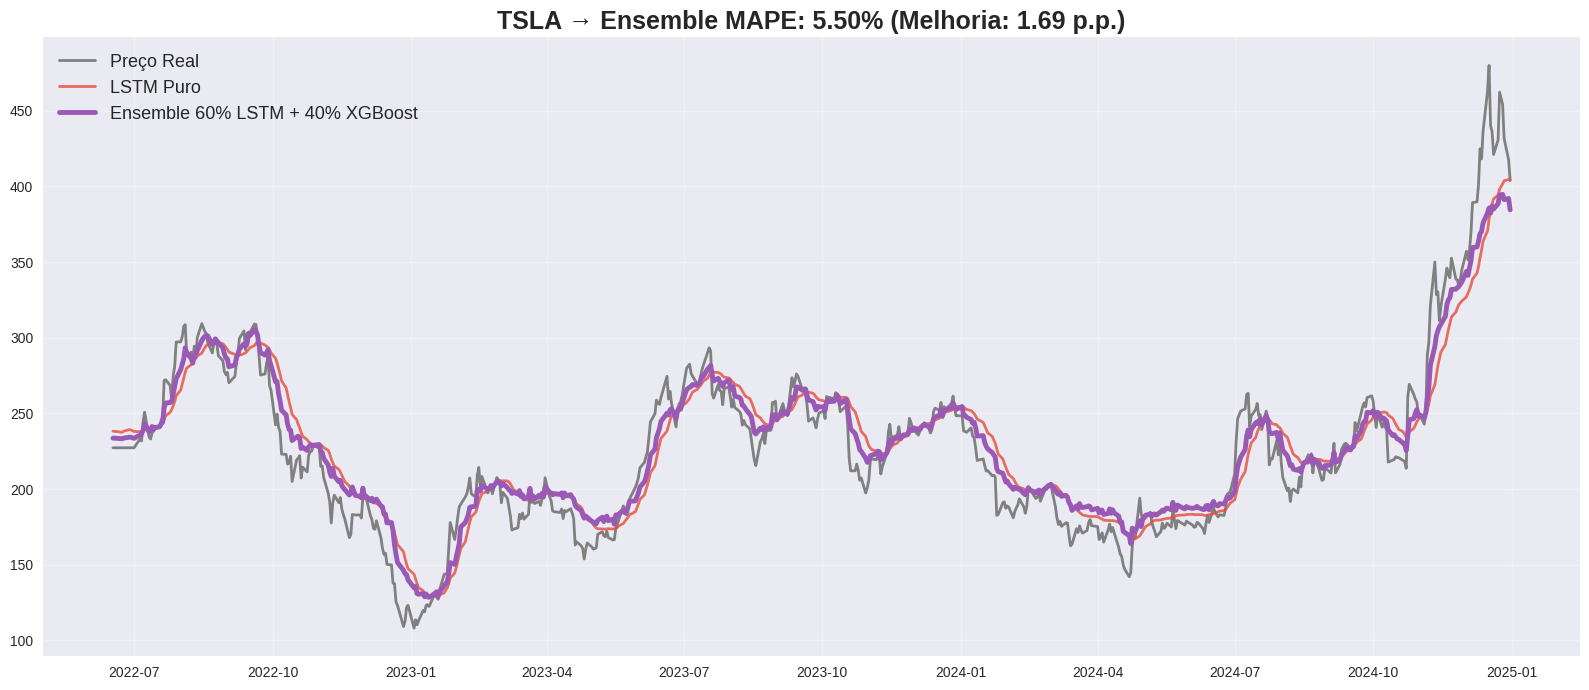

Ativos:  85%|████████▌ | 17/20 [38:26<05:59, 119.97s/it]

   LSTM: 7.19% → Ensemble: 5.50% | Dir: 79.4%

→ Processando NFLX...
   LSTM → NFLX | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 7s 210ms/step - loss: 5.8618e-04 - val_loss: 0.0033 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 0.0169 - val_loss: 0.0342 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 221ms/step - loss: 0.0015 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 225ms/step - loss: 3.5236e-04 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step - loss: 5.1263e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 6.6435e-04 - val_loss: 0.0013 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 235ms/step - loss: 7.1706e-04 - val_loss: 9.2554e-04 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 219ms/step - loss: 2.3441e-04 - va

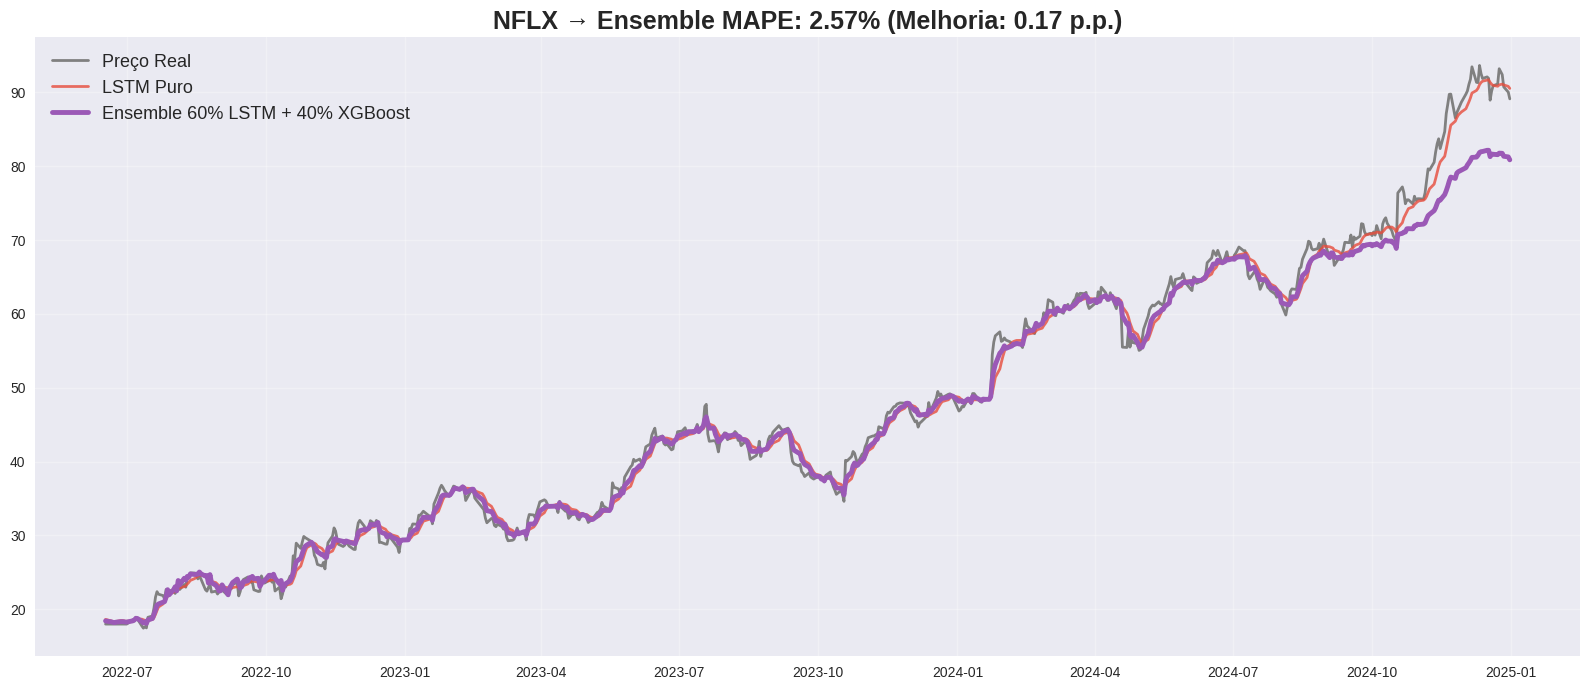

Ativos:  90%|█████████ | 18/20 [40:56<04:17, 128.95s/it]

   LSTM: 2.74% → Ensemble: 2.57% | Dir: 76.5%

→ Processando ADBE...
   LSTM → ADBE | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 212ms/step - loss: 6.7974e-04 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - loss: 0.0279 - val_loss: 0.0734 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 192ms/step - loss: 8.1894e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 3.0516e-04 - val_loss: 0.0015 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 267ms/step - loss: 3.9141e-04 - val_loss: 0.0012 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 194ms/step - loss: 6.3799e-04 - val_loss: 9.6878e-04 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 189ms/step - loss: 9.7176e-04 - val_loss: 0.0011 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 232ms/step - loss: 7.4969e-04 

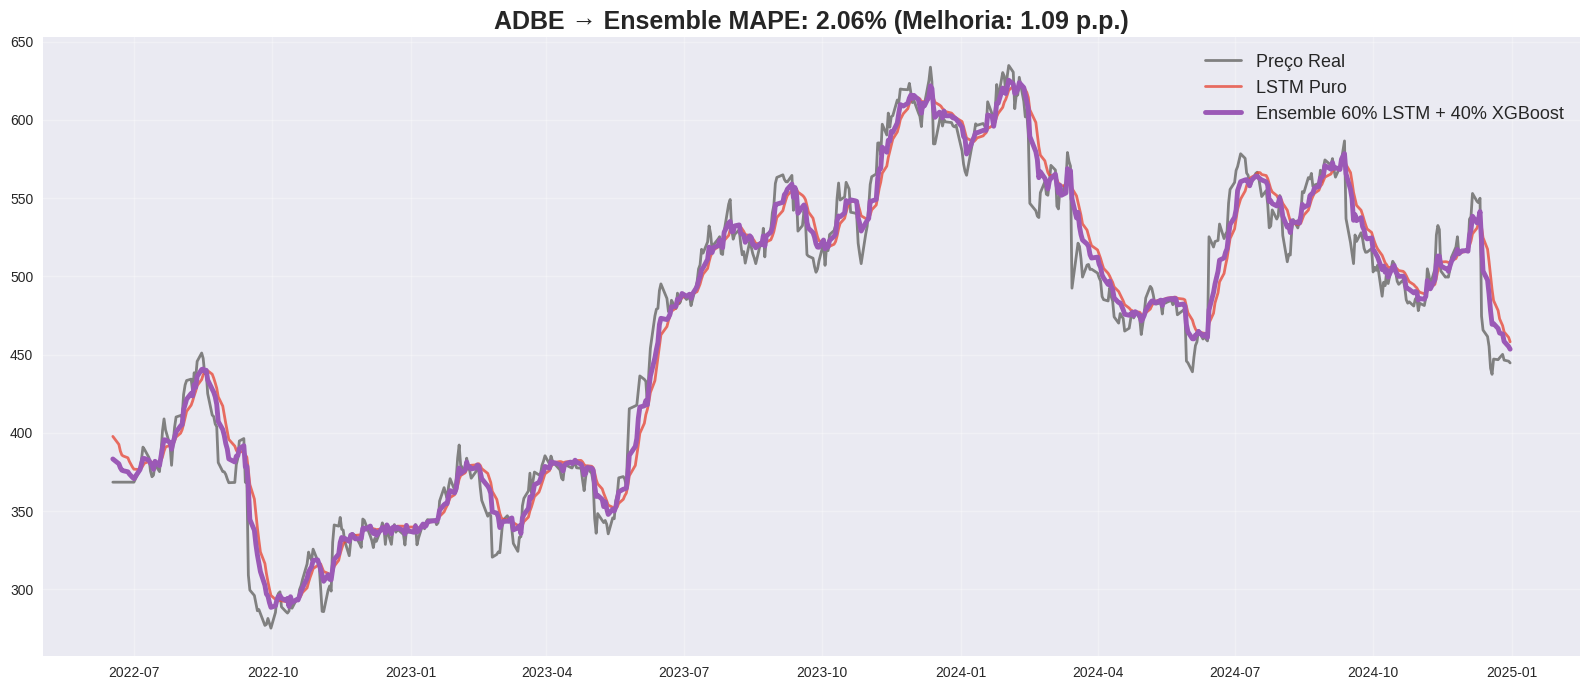

Ativos:  95%|█████████▌| 19/20 [42:13<01:53, 113.27s/it]

   LSTM: 3.15% → Ensemble: 2.06% | Dir: 82.1%

→ Processando INTC...
   LSTM → INTC | 3251 dias | look_back=60
   Treinando LSTM...Epoch 1/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 222ms/step - loss: 0.0106 - val_loss: 0.0031 - learning_rate: 0.0010
Epoch 2/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - loss: 0.0165 - val_loss: 0.0139 - learning_rate: 0.0010
Epoch 3/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 0.0134 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 4/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 193ms/step - loss: 0.0013 - val_loss: 0.0020 - learning_rate: 0.0010
Epoch 5/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 222ms/step - loss: 8.3778e-04 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 6/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 5s 190ms/step - loss: 0.0011 - val_loss: 0.0018 - learning_rate: 0.0010
Epoch 7/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 190ms/step - loss: 9.2240e-04 - val_loss: 0.0016 - learning_rate: 0.0010
Epoch 8/80
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 191ms/step - loss: 8.8574e-04 - val_loss: 0.0020 -

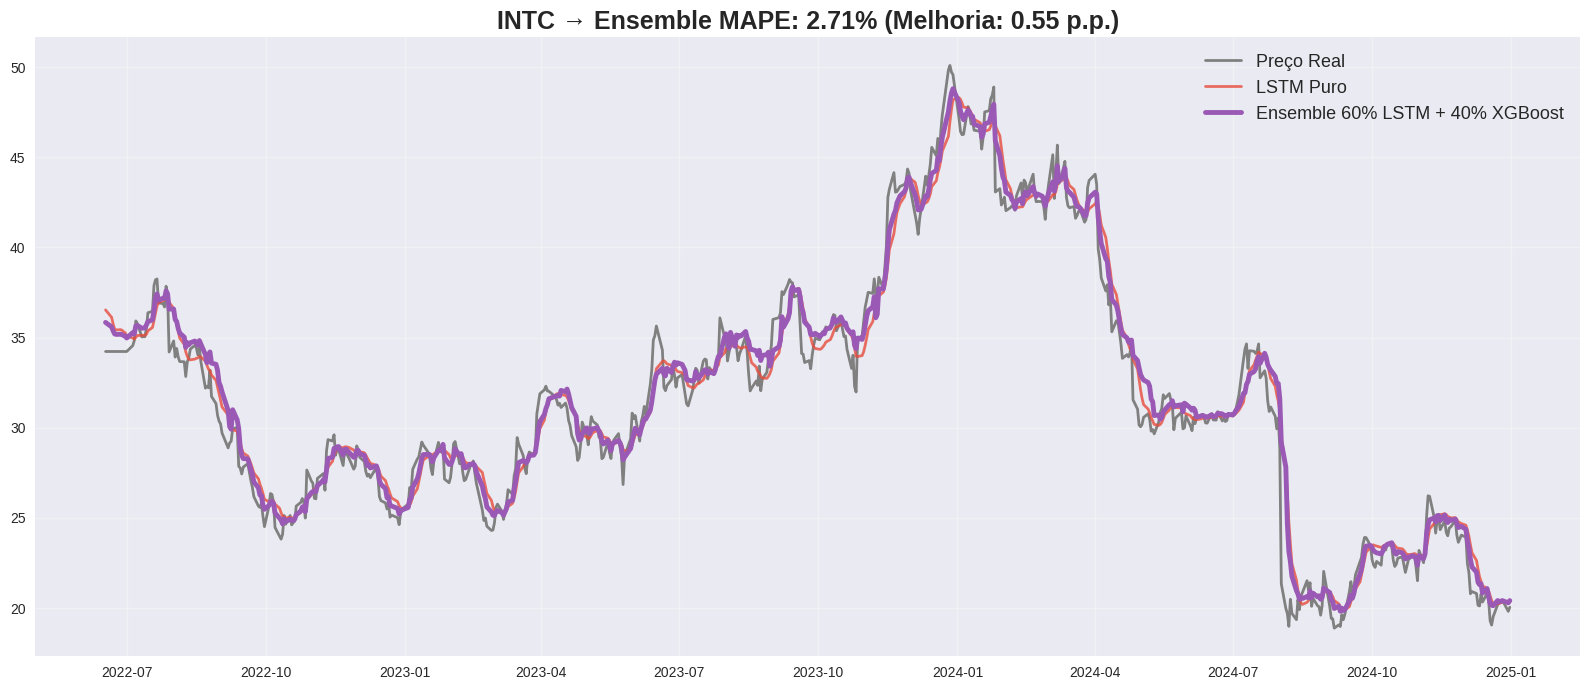

Ativos: 100%|██████████| 20/20 [44:39<00:00, 133.97s/it]

   LSTM: 3.26% → Ensemble: 2.71% | Dir: 77.7%

TREINAMENTO CONCLUÍDO EM 2679.5 SEGUNDOS (44.7 minutos)!
→ 20 ativos processados com sucesso.


In [27]:
# =============================================
# FASE 3 — LSTM + XGBoost (VERSÃO FINAL TURBO 2025)
# =============================================
import numpy as np
import pandas as pd
import tensorflow as tf
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
from tqdm import tqdm
import matplotlib.pyplot as plt

start_time = time.time()

# -------------------------------------------------
# Função de criação de sequências
# -------------------------------------------------
def create_sequences(data, look_back):
    data = np.array(data, dtype=np.float32).flatten()
    if len(data) <= look_back:
        return np.array([]), np.array([])
    X = np.lib.stride_tricks.sliding_window_view(data, window_shape=look_back)
    y = data[look_back:]
    return X[..., np.newaxis], y

# -------------------------------------------------
# LSTM TURBO
# -------------------------------------------------
def treinar_lstm_puro(df, nome, look_back=60):
    print(f"   LSTM → {nome} | {len(df)} dias | look_back={look_back}")

    if len(df) < look_back + 200:
        print(f"   Dados insuficientes para {nome}")
        return None, None, None, None, None

    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[['Close']]).flatten()

    X, y = create_sequences(scaled, look_back)
    if len(X) == 0:
        return None, None, None, None, None

    split = int(0.8 * len(X))
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    model = Sequential([
        LSTM(64, input_shape=(look_back, 1)),
        Dropout(0.2),
        Dense(32, activation='relu'),
        Dense(1, dtype='float32')
    ])
    model.compile(optimizer='adam', loss='mse')

    callbacks = [
        EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss', verbose=1),
        ReduceLROnPlateau(patience=7, factor=0.5, monitor='val_loss', verbose=1)
    ]

    print(f"   Treinando LSTM...", end="")

    history = model.fit(
        X_train, y_train,
        epochs=80,
        batch_size=128,
        validation_split=0.2,
        verbose=1,
        shuffle=False,
        callbacks=callbacks
    )

    epocas = len(history.history['loss'])
    print(f"   LSTM concluída em {epocas}/80 épocas!",
          "EarlyStopping ativado!" if epocas < 80 else "")

    pred_scaled = model.predict(X_test, verbose=0)
    pred = scaler.inverse_transform(pred_scaled).flatten()
    real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

    # Datas corretas para test
    dates = df.index[split + look_back : split + look_back + len(pred)]

    return model, scaler, pred, real, dates

# -------------------------------------------------
# XGBoost
# -------------------------------------------------
def treinar_xgboost(df, nome, look_back=60):
    print(f"   XGBoost → {nome}")
    data = df.copy()

    # Features
    for lag in [1, 3, 5, 10, 20, 60]:
        data[f'lag_{lag}'] = data['Close'].shift(lag)
    for p in [1, 5, 10, 20]:
        data[f'ret_{p}'] = data['Close'].pct_change(p)
    data['vol_20'] = data['Close'].pct_change().rolling(20).std()
    data['rsi'] = data['RSI'].fillna(50) if 'RSI' in data.columns else 50.0
    data['ema_60'] = data['Close'].ewm(span=60).mean()
    data['close_ratio'] = data['Close'] / data['ema_60']

    # Não resetar índice
    data = data.iloc[look_back + 50:].dropna()

    if len(data) < 300:
        return None, None, None

    X = data.drop(['Close', 'Open', 'High', 'Low', 'Volume'], axis=1, errors='ignore')
    y = data['Close']
    split = int(0.8 * len(data))

    model = XGBRegressor(
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        tree_method='hist',
        n_jobs=-1
    )
    model.fit(X.iloc[:split], y.iloc[:split])

    pred = model.predict(X.iloc[split:])
    real = y.iloc[split:].values
    dates = X.iloc[split:].index

    return pred, real, dates

# -------------------------------------------------
# Métricas
# -------------------------------------------------
def calcular_metricas(real, pred):
    real = np.array(real)
    pred = np.array(pred)
    eps = 1e-9

    mape = np.mean(np.abs((real - pred) / (real + eps))) * 100
    dir_acc = np.mean(np.sign(np.diff(real)) == np.sign(np.diff(pred))) * 100 if len(real) > 1 else 0.0

    ss_res = np.sum((real - pred) ** 2)
    ss_tot = np.sum((real - np.mean(real)) ** 2) + eps
    r2 = 1 - ss_res / ss_tot

    return {'MAPE (%)': mape, 'Acurácia Direcional (%)': dir_acc, 'R²': r2, 'F1 Tendência': 0.0}

# -------------------------------------------------
# LOOP PRINCIPAL
# -------------------------------------------------
resultados = []

print("\n" + "═"*100)
print("INICIANDO TREINAMENTO TURBO → 60% LSTM + 40% XGBoost")
print("═"*100)

for ticker, df in tqdm(todos_ativos.items(), desc="Ativos", colour="#9b59b6"):
    nome = ticker.replace('.SA', '')

    try:
        if len(df) < 1300:
            print(f"   {nome} → dados insuficientes ({len(df)} dias)")
            continue

        print(f"\n→ Processando {nome}...")

        # 1. LSTM
        lstm_out = treinar_lstm_puro(df, nome)
        if lstm_out[0] is None:
            print(f"   LSTM falhou em {nome}")
            continue

        _, _, pred_lstm, real_lstm, dates_lstm = lstm_out

        # 2. XGBoost
        xgb_out = treinar_xgboost(df, nome)
        if xgb_out[0] is None:
            print(f"   XGBoost falhou em {nome}")
            continue

        pred_xgb_raw, real_xgb_raw, dates_xgb_raw = xgb_out

        # =============================================
        # ALINHAMENTO FINAL INFALÍVEL
        # =============================================
        if len(pred_xgb_raw) >= len(pred_lstm):
            pred_xgb = pred_xgb_raw[-len(pred_lstm):]
            real_xgb = real_xgb_raw[-len(pred_lstm):]
        else:
            deficit = len(pred_lstm) - len(pred_xgb_raw)
            pred_xgb = np.concatenate([np.full(deficit, pred_xgb_raw[0]), pred_xgb_raw])
            real_xgb = np.concatenate([np.full(deficit, real_xgb_raw[0]), real_xgb_raw])

        n = min(len(pred_lstm), len(pred_xgb), len(real_xgb), len(dates_lstm))

        pred_lstm = pred_lstm[-n:]
        pred_xgb  = pred_xgb[-n:]
        real_xgb  = real_xgb[-n:]
        dates_lstm = dates_lstm[-n:]

        df_align = pd.DataFrame({
            'real': real_xgb,
            'lstm': pred_lstm,
            'xgb': pred_xgb
        }, index=dates_lstm)

        if len(df_align) < 50:
            print(f"   Poucos pontos alinhados em {nome}")
            continue

        # Ensemble
        ensemble = df_align['lstm'] * 0.60 + df_align['xgb'] * 0.40

        # Métricas
        met_lstm = calcular_metricas(df_align['real'], df_align['lstm'])
        met_ens  = calcular_metricas(df_align['real'], ensemble)

        # Gráfico
        plt.figure(figsize=(16, 7))
        plt.plot(df_align.index, df_align['real'], label='Preço Real', color='gray', linewidth=2)
        plt.plot(df_align.index, df_align['lstm'], label='LSTM Puro', color='#e74c3c', alpha=0.8, linewidth=2)
        plt.plot(df_align.index, ensemble, label='Ensemble 60% LSTM + 40% XGBoost', color='#9b59b6', linewidth=3.5)
        plt.title(
            f"{nome} → Ensemble MAPE: {met_ens['MAPE (%)']:.2f}% "
            f"(Melhoria: {met_lstm['MAPE (%)'] - met_ens['MAPE (%)']:.2f} p.p.)",
            fontsize=18, fontweight='bold'
        )
        plt.legend(fontsize=13)
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()

        print(f"   LSTM: {met_lstm['MAPE (%)']:.2f}% → Ensemble: {met_ens['MAPE (%)']:.2f}% | "
              f"Dir: {met_ens['Acurácia Direcional (%)']:.1f}%")

        resultados.append({
            'Ativo': nome,
            'País': 'Brasil' if '.SA' in ticker else 'EUA',
            'LSTM MAPE (%)': met_lstm['MAPE (%)'],
            'Ensemble MAPE (%)': met_ens['MAPE (%)'],
            'Melhoria (p.p.)': round(met_lstm['MAPE (%)'] - met_ens['MAPE (%)'], 2),
            'Acurácia Direcional (%)': met_ens['Acurácia Direcional (%)'],
            'F1 Tendência': met_ens['F1 Tendência'],
            'R²': met_ens['R²']
        })

    except Exception as e:
        print(f"   ERRO CRÍTICO em {nome}: {e}")
        import traceback
        traceback.print_exc()
        continue

# =============================================
# FINALIZAÇÃO
# =============================================
tempo_total = time.time() - start_time
print(f"\nTREINAMENTO CONCLUÍDO EM {tempo_total:.1f} SEGUNDOS ({tempo_total/60:.1f} minutos)!")
print(f"→ {len(resultados)} ativos processados com sucesso.")


In [29]:
# =============================================
# Fase Final
# =============================================

if resultados:
    df_final = pd.DataFrame(resultados).sort_values('Ensemble MAPE (%)')

    display(
        df_final.style
        .bar(subset=['Ensemble MAPE (%)'], color='#ff6b6b')
        .bar(subset=['Melhoria (p.p.)'], color='#1abc9c')
        .bar(subset=['Acurácia Direcional (%)'], color='#3498db')
        .format({
            'Ensemble MAPE (%)': '{:.2f}',
            'Melhoria (p.p.)': '{:.2f}',
            'Acurácia Direcional (%)': '{:.2f}'
        })
        .set_caption("RANKING FINAL - Ensemble 60% LSTM + 40% XGBoost")
        .set_table_styles([{
            'selector': 'caption',
            'props': [
                ('font-size', '20pt'),
                ('font-weight', 'bold'),
                ('color', '#2c3e50')
            ]
        }])
    )

    br = df_final[df_final['País'] == 'Brasil']['Ensemble MAPE (%)'].mean()
    eua = df_final[df_final['País'] == 'EUA']['Ensemble MAPE (%)'].mean()
    dir_br = df_final[df_final['País'] == 'Brasil']['Acurácia Direcional (%)'].mean()
    dir_eua = df_final[df_final['País'] == 'EUA']['Acurácia Direcional (%)'].mean()

    print(f"\nMÉDIA FINAL DOS 20 ATIVOS:")
    print(f"   Brasil:     MAPE {br:.2f}% | Dir: {dir_br:.1f}%")
    print(f"   EUA:        MAPE {eua:.2f}% | Dir: {dir_eua:.1f}%")
    print(f"   Big Techs são {(br/eua - 1)*100:.1f}% mais previsíveis que ações brasileiras!")
else:
    print("Nenhum ativo foi processado com sucesso.")



MÉDIA FINAL DOS 20 ATIVOS:
   Brasil:     MAPE 4.55% | Dir: 80.6%
   EUA:        MAPE 5.81% | Dir: 79.0%
   Big Techs são -21.6% mais previsíveis que ações brasileiras!
